# Experiment 1: Test TimeMIL on the extracted dataset

## load and prepare datast

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = "/content/drive/MyDrive/Colab Notebooks/work_project/notebooks/final_datasets_experiments/single_platforms_DailyBoxOffice/df_twitter_DailyBoxOffice_final_3_classes.parquet"
dataset= pd.read_parquet(path)

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31556 entries, 0 to 31555
Data columns (total 33 columns):
 #   Column                                                              Non-Null Count  Dtype         
---  ------                                                              --------------  -----         
 0   twitter_imdbId_fixed_x                                              31556 non-null  object        
 1   twitter_title_clean                                                 31556 non-null  object        
 2   twitter_year_released                                               31556 non-null  int32         
 3   twitter_year_month_day                                              31556 non-null  datetime64[ns]
 4   twitter_number_reviews                                              31556 non-null  int64         
 5   twitter_rating_mean                                                 31556 non-null  float64       
 6   twitter_rating_median                                 

First, since there might be errors in the values for days_since_first_rating and days_after_release, these values will be recreated again.

In [5]:
import pandas as pd

# Assuming `dataset` is your DataFrame
# First, sort the dataset as you mentioned
dataset.sort_values(by=["from_imdb_imdb_id", "daily_box_office_date_revenue_recorded"], inplace=True)

# Calculate `days_after_release` as the difference between review date and original release date
dataset['days_after_release'] = (dataset['daily_box_office_date_revenue_recorded'] - dataset['daily_box_office_movie_release_date']).dt.days

# Calculate the first rating date per movie and merge back into the main dataset
first_rating_dates = dataset.groupby('from_imdb_imdb_id')['daily_box_office_date_revenue_recorded'].min().reset_index()
first_rating_dates.rename(columns={'daily_box_office_date_revenue_recorded': 'first_rating_date_recalculated'}, inplace=True)

# Merge the recalculated first rating dates back into the main DataFrame
dataset = dataset.merge(first_rating_dates, on='from_imdb_imdb_id', how='left')

# Calculate `days_since_first_rating` as the difference between each review date and the recalculated first rating date
dataset['days_since_first_rating'] = (dataset['daily_box_office_date_revenue_recorded'] - dataset['first_rating_date_recalculated']).dt.days

# Drop the helper column if no longer needed
dataset.drop(columns=['first_rating_date_recalculated'], inplace=True)

# Calculate the first and last rating dates per movie
rating_dates = dataset.groupby('from_imdb_imdb_id')['daily_box_office_date_revenue_recorded'].agg(
    first_rating_date=('min'),
    last_rating_date=('max')
).reset_index()

# Calculate the difference in days between the first and last rating dates
rating_dates['days_between_first_and_last_rating'] = (rating_dates['last_rating_date'] - rating_dates['first_rating_date']).dt.days

# Merge this back into the main dataset
dataset = dataset.merge(rating_dates[['from_imdb_imdb_id', 'days_between_first_and_last_rating']], on='from_imdb_imdb_id', how='left')


# Verify the updates
dataset[['from_imdb_imdb_id', 'daily_box_office_date_revenue_recorded', 'days_after_release', 'days_since_first_rating', "days_between_first_and_last_rating"]].head()


,from_imdb_imdb_id,daily_box_office_date_revenue_recorded,days_after_release,days_since_first_rating,days_between_first_and_last_rating
0,tt0004972,2016-11-12,37127,0,0
1,tt0012349,2019-03-13,35829,0,0
2,tt0058898,2014-04-04,17866,0,36
3,tt0058898,2014-04-30,17892,26,36
4,tt0058898,2014-05-10,17902,36,36


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31556 entries, 0 to 31555
Data columns (total 34 columns):
 #   Column                                                              Non-Null Count  Dtype         
---  ------                                                              --------------  -----         
 0   twitter_imdbId_fixed_x                                              31556 non-null  object        
 1   twitter_title_clean                                                 31556 non-null  object        
 2   twitter_year_released                                               31556 non-null  int32         
 3   twitter_year_month_day                                              31556 non-null  datetime64[ns]
 4   twitter_number_reviews                                              31556 non-null  int64         
 5   twitter_rating_mean                                                 31556 non-null  float64       
 6   twitter_rating_median                                 

Within the analysis, only movies with more than 4 weeks of ratings will be included. Also, to ensure that the movies remain compareable, movies with not more than 365 days will be excluded.

Check number movies before filtering to ensure enough movies available

In [7]:
dataset[(dataset['numberDays'] >= 28) & (dataset['numberDays'] <= 365)]["from_imdb_imdb_id"].unique().shape

(396,)

Next, we will investigate missing entries for variances to understand how we will handle them correctly.

In [8]:
# count number of entries with var and std not null per movie
# dataset_var_counted = dataset[dataset["from_imdb_daily_var_rating"].isna() == False].groupby(["from_imdb_imdb_id", "numberDays"])\
# .agg(numberDaysVar=("from_imdb_daily_var_rating", "count"))\
# .reset_index() \
# .sort_values(by="numberDaysVar", ascending=True)

# dataset_var_counted[dataset_var_counted["numberDaysVar"] > 10]

As many of the variance and std features contain missing values, these entries need to be handled.

Looking at how the data was aggregated (ratings statistics per day), one can conclude that a missing variance  indicates that there was only one rating recorded on this day. Thus if might be a feasible approach to impute the ones with missing values with a variance of ***0*** as it would reflect the as is state of the entries on that day. Thus, missing values will be imputed with ***0*** for std and var features.

However, before this step is done, it is necessary to filter the dataset to the final volume as only movies with more than 28 or less than 365 data entries will be included in the analysis. This will ensure that the data has enough samples for temporal feature extraction within a time range that is acceptable.

number_days    39.99493
dtype: float64
min_number_days    1
dtype: int64
max_number_days    207
dtype: int64
Number unique movies: (789,)


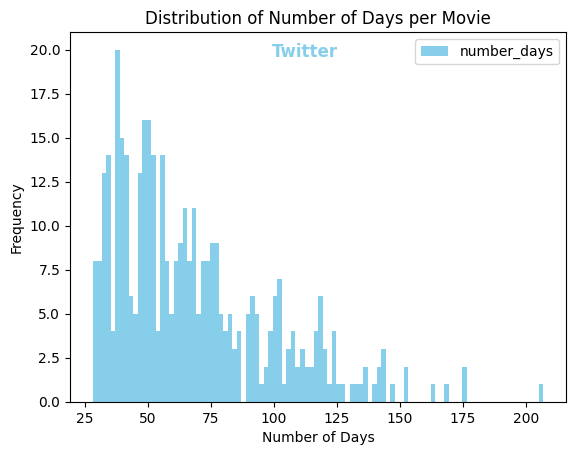

Shape only movies with more than 14 days:  (391, 2)



========================Applying Filters=============================
Applying filter so only include movies equal or after 'daily_box_office_movie_release_date':
.. filtered number_unique_days 
	'dataset['daily_box_office_date_revenue_recorded'] >= dataset['rotten_original_release_date']'
Number of unique movies: (777,)
Shape data: (30751, 34)
Stats:
      daily_box_office_date_revenue_recorded  twitter_rating_mean  \
count                                  30751         30751.000000   
mean           2015-03-30 11:13:20.169100032             7.193094   
min                      2013-02-28 00:00:00             0.000000   
25%                      2014-01-31 12:00:00             6.500000   
50%                      2015-02-20 00:00:00             7.333333   
75%                      2016-05-16 00:00:00             8.000000   
max                      2019-11-30 00:00:00            10.000000   
std                                    

In [11]:
print(dataset.groupby("from_imdb_imdb_id").agg(number_days = ("daily_box_office_DailyBoxOfficeRevenue", "count")).mean())
print(dataset.groupby("from_imdb_imdb_id").agg(min_number_days = ("daily_box_office_DailyBoxOfficeRevenue", "count")).min())
print(dataset.groupby("from_imdb_imdb_id").agg(max_number_days = ("daily_box_office_DailyBoxOfficeRevenue", "count")).max())
print(f'Number unique movies: {dataset["from_imdb_imdb_id"].unique().shape}')

# check number of movies with more than 14 days
check_days = dataset.groupby("from_imdb_imdb_id").agg(number_days = ("daily_box_office_date_revenue_recorded", "nunique")).reset_index()

# plot distribution of number of days as barplot
#check_days[check_days["number_days"] >= 28].plot(kind="hist", bins=100, color="skyblue")
ax = check_days[check_days["number_days"] >= 28].plot(kind="hist", bins=100, color="skyblue")
plt.title("Distribution of Number of Days per Movie")  # Add title
plt.xlabel("Number of Days")             # Optional: Add x-axis label
plt.ylabel("Frequency")                  # Optional: Add y-axis label
# Add an annotation in the top-right corner
plt.annotate(
    "Twitter",          # The text for the annotation
    xy=(0.54, 0.97),            # Position in the axes coordinates (0 to 1)
    xycoords="axes fraction",   # Use axes fraction to position relative to the plot
    fontsize=12,                # Font size
    color="skyblue",                # Text color
    ha="right",                 # Horizontal alignment
    va="top",                    # Vertical alignment
    fontweight="bold"
    )
plt.show()

print("Shape only movies with more than 14 days: ", check_days[check_days["number_days"] > 28].shape)

# applying filtering to only include entries equal or after the movies release
print("\n\n\n=====================================================================")
print("========================Applying Filters=============================")
print("=====================================================================")

print("Applying filter so only include movies equal or after 'daily_box_office_movie_release_date':")
dataset_valid = dataset[dataset["daily_box_office_date_revenue_recorded"]>= dataset["daily_box_office_movie_release_date"]]
print(".. filtered number_unique_days \n\t'dataset['daily_box_office_date_revenue_recorded'] >= dataset['rotten_original_release_date']'")
print("=====================================================================")
print("=====================================================================")

print(f"Number of unique movies: {dataset_valid['from_imdb_imdb_id'].unique().shape}")
print(f"Shape data: {dataset_valid.shape}")
print("=====================================================================")

print(f'Stats:')
print(dataset_valid[["from_imdb_imdb_id",
                     "daily_box_office_date_revenue_recorded",
                     "twitter_rating_mean",
                     "daily_box_office_DailyBoxOfficeRevenue",
                     "daily_box_office_Theaters_cleaned"]].describe())

per_movie = dataset_valid[["from_imdb_imdb_id", "daily_box_office_date_revenue_recorded", "twitter_rating_mean",
                           "daily_box_office_DailyBoxOfficeRevenue", "daily_box_office_Theaters_cleaned"]]

days_per_movie = per_movie.groupby("from_imdb_imdb_id").agg(number_days_new = ("daily_box_office_date_revenue_recorded", "count"),
                                                            number_unique_days = ("daily_box_office_date_revenue_recorded", "nunique")).reset_index().sort_values(by="number_days_new", ascending=False)
print("=====================================================================")
print("=====================================================================")
print("Applying filter to only include movies with more than 28 days:")
days_per_movie = days_per_movie[(days_per_movie["number_unique_days"]>=28)]
print(".. filtered number_unique_days '>=28'")
print("=====================================================================")

print(f"Shape only movies with more than 28 days: {days_per_movie.shape}")
print(days_per_movie.describe())

# merge back to original data
movies_sequences = dataset.merge(days_per_movie, left_on="from_imdb_imdb_id", right_on="from_imdb_imdb_id", how="inner")

print("Number total samples: ", movies_sequences.shape)
print("Number unique movies: ", movies_sequences["from_imdb_imdb_id"].unique().shape)

In [ ]:
movies_sequences.isna().sum()

,0
twitter_imdbId_fixed_x,0
twitter_title_clean,0
twitter_year_released,0
twitter_year_month_day,0
twitter_number_reviews,0
twitter_rating_mean,0
twitter_rating_median,0
twitter_rating_min,0
twitter_rating_max,0
twitter_number_users,0


In [ ]:
movies_sequences.columns

Index(['twitter_imdbId_fixed_x', 'twitter_title_clean',
       'twitter_year_released', 'twitter_year_month_day',
       'twitter_number_reviews', 'twitter_rating_mean',
       'twitter_rating_median', 'twitter_rating_min', 'twitter_rating_max',
       'twitter_number_users', 'from_imdb_id', 'from_imdb_imdb_id',
       'from_budgets_release_date', 'daily_box_office_movie_release_date',
       'daily_box_office_date_revenue_recorded',
       'daily_box_office_custom_date_revenue_recorded',
       'daily_box_office_TotalBoxOffice_lifespan',
       'daily_box_office_DailyBoxOfficeRevenue',
       'daily_box_office_accumulated_DailyBoxOfficeRevenues_since_Realease',
       'daily_box_office_%± YD gross change daily',
       'daily_box_office_%± LW gross change weekly',
       'daily_box_office_per theaters avg gross',
       'daily_box_office_Theaters_cleaned',
       'daily_box_office_from_imdb_imdb_id',
       'daily_box_office_from_imdb_release_date',
       'daily_box_office_from_imdb_

In [ ]:
# cols_to_remove = [     'from_imdb_id',
#       #'from_imdb_imdb_id',
#       'from_imdb_title',
#       'from_imdb_release_date',
#       'from_imdb_release_date_tmdb',
#       'from_imdb_rating_date',
#       #'from_imdb_daily_mean_rating',
#       #'from_imdb_daily_median_rating',
#       #'from_imdb_daily_var_rating',
#       #'from_imdb_daily_std_rating',
#       #'from_imdb_daily_min_rating',
#       #'from_imdb_daily_max_rating',
#       #'from_imdb_daily_number_of_ratings',
#       #'from_imdb_daily_number_of_users',
#       #'from_imdb_days_since_first_rating',
#       #'daily_box_office_movie_release_date',
#       #'daily_box_office_date_revenue_recorded',
#       #'daily_box_office_TotalBoxOffice_lifespan',
#       #'daily_box_office_DailyBoxOfficeRevenue',
#       #'daily_box_office_accumulated_DailyBoxOfficeRevenues_since_Realease',
#       #'daily_box_office_%± YD gross change daily',
#       #'daily_box_office_%± LW gross change weekly',
#       #'daily_box_office_per theaters avg gross',
#       #'daily_box_office_Theaters_cleaned',
#       'daily_box_office_from_imdb_release_date',
#       'daily_box_office_from_imdb_release_date_tmdb',
#       #'Success_Label',
#       'numberDays',
#       'first_rating_date',
#       #'days_after_release',
#       #'days_since_first_rating',
#       #'days_between_first_and_last_rating',
#       'number_days_new',
#       'number_unique_days'
#       ]

In [ ]:
cols_to_remove = ['twitter_imdbId_fixed_x',
                  'twitter_title_clean',
                  'twitter_year_released',
                  'twitter_year_month_day',
                  # 'twitter_number_reviews',
                  # 'twitter_rating_mean',
                  # 'twitter_rating_median',
                  # 'twitter_rating_min',
                  # 'twitter_rating_max',
                  # 'twitter_number_users',
                  'from_imdb_id',
                  #'from_imdb_imdb_id',
                  'from_budgets_release_date',
                  # 'daily_box_office_movie_release_date',
                  # 'daily_box_office_date_revenue_recorded',
                  'daily_box_office_custom_date_revenue_recorded',
                  # 'daily_box_office_TotalBoxOffice_lifespan',
                  # 'daily_box_office_DailyBoxOfficeRevenue',
                  # 'daily_box_office_accumulated_DailyBoxOfficeRevenues_since_Realease',
                  # 'daily_box_office_%± YD gross change daily',
                  # 'daily_box_office_%± LW gross change weekly',
                  # 'daily_box_office_per theaters avg gross',
                  # 'daily_box_office_Theaters_cleaned',
                  'daily_box_office_from_imdb_imdb_id',
                  'daily_box_office_from_imdb_release_date',
                  'daily_box_office_from_imdb_release_date_tmdb',
                  'daily_box_office_Theaters_cleaned_filled_missing',
                  'twitter_imdbId_fixed_y',
                  #'Success_Label',
                  'numberDays',
                  'first_rating_date',
                  # 'days_after_release',
                  # 'days_since_first_rating',
                  # 'days_between_first_and_last_rating',
                  'number_days_new',
                  'number_unique_days'
                  ]

movies_sequences.drop(columns=cols_to_remove, inplace=True)
movies_sequences.reset_index(drop=True, inplace=True)
movies_sequences.sort_values(by=["from_imdb_imdb_id", "daily_box_office_date_revenue_recorded"], inplace=True)


In [ ]:
movies_sequences.fillna(0, inplace=True)

In [ ]:
movies_sequences.isna().sum()

,0
twitter_number_reviews,0
twitter_rating_mean,0
twitter_rating_median,0
twitter_rating_min,0
twitter_rating_max,0
twitter_number_users,0
from_imdb_imdb_id,0
daily_box_office_movie_release_date,0
daily_box_office_date_revenue_recorded,0
daily_box_office_TotalBoxOffice_lifespan,0


Next, the dataset will be reduced to only the columns necessary for the final predictive modelling task to make the pipeline more efficient.

Next, the target label will be encoded in the target column.

In [ ]:
movies_sequences['Success_Label'].unique()

array(['1_Average (1)', '2_Blockbuster (2)', '0_Flop (0)'], dtype=object)

In [ ]:
# encoding Success_Label for 6 classes
# label_mapping = {
#           '1_Box Office Bomb (1)': 1,
#           '2_Flop (2)': 2,
#           '3_Average (3)': 3,
#           '4_Hit (4)': 4,
#           '5_Superhit (5)': 5,
#           '6_Blockbuster (6)': 6,
#           }

# encoding Success_Label for 3 classes
label_mapping_2 = {
          '0_Flop (0)': 0,
          '1_Average (1)': 1,
          '2_Blockbuster (2)': 2,
          }

movies_sequences['Success_Label'] = movies_sequences['Success_Label'].map(label_mapping_2)

In [ ]:
movies_sequences.head()

,twitter_number_reviews,twitter_rating_mean,twitter_rating_median,twitter_rating_min,twitter_rating_max,twitter_number_users,from_imdb_imdb_id,daily_box_office_movie_release_date,daily_box_office_date_revenue_recorded,daily_box_office_TotalBoxOffice_lifespan,daily_box_office_DailyBoxOfficeRevenue,daily_box_office_accumulated_DailyBoxOfficeRevenues_since_Realease,daily_box_office_%± YD gross change daily,daily_box_office_%± LW gross change weekly,daily_box_office_per theaters avg gross,daily_box_office_Theaters_cleaned,Success_Label,days_after_release,days_since_first_rating,days_between_first_and_last_rating
0,10,7.700000,7.0,6,10,10,tt0359950,2013-12-25,2013-12-25,58236838.0,7813372.0,7813372.0,0.0,0.0,2685.0,2909.0,1,0,0,92
1,18,7.111111,7.0,4,9,18,tt0359950,2013-12-25,2013-12-26,58236838.0,4781588.0,12594960.0,-38.8,0.0,1643.0,2909.0,1,1,1,92
2,22,7.454545,7.5,3,10,22,tt0359950,2013-12-25,2013-12-27,58236838.0,4535301.0,17130261.0,-5.2,0.0,1559.0,2909.0,1,2,2,92
3,24,7.875000,8.0,4,10,24,tt0359950,2013-12-25,2013-12-28,58236838.0,4758452.0,21888713.0,4.9,0.0,1635.0,2909.0,1,3,3,92
4,17,8.235294,8.0,6,10,17,tt0359950,2013-12-25,2013-12-29,58236838.0,3471755.0,25360468.0,-27.0,0.0,1193.0,2909.0,1,4,4,92


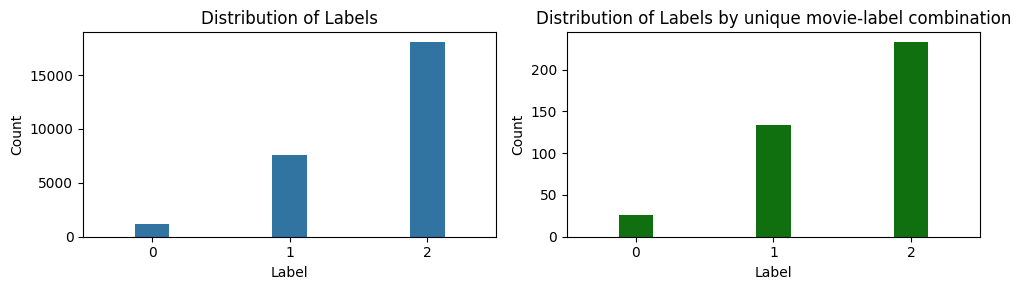

In [ ]:
# Create a 1x2 subplot
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Plot distribution of labels on the first subplot
data1 = movies_sequences['Success_Label'].value_counts()
sns.barplot(x=data1.index, y=data1.values, ax=axes[0], width=0.25)
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Labels')

# Plot distribution of labels per movie on the second subplot
data2 = movies_sequences[["from_imdb_imdb_id", "Success_Label"]].drop_duplicates()["Success_Label"].value_counts()
sns.barplot(x=data2.index, y=data2.values, ax=axes[1], color="green", width=0.25)
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution of Labels by unique movie-label combination')


# Display the plots
plt.tight_layout()
plt.show()

Applying some filters to select only movies useful for the experiment.(movies with at least sum of 28 days of entries or maximum 365 days of days)

In [ ]:
movies_sequences["from_imdb_imdb_id"].unique().shape

(393,)

In [ ]:
movies_sequences.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26848 entries, 0 to 26847
Data columns (total 20 columns):
 #   Column                                                              Non-Null Count  Dtype         
---  ------                                                              --------------  -----         
 0   twitter_number_reviews                                              26848 non-null  int64         
 1   twitter_rating_mean                                                 26848 non-null  float64       
 2   twitter_rating_median                                               26848 non-null  float64       
 3   twitter_rating_min                                                  26848 non-null  int64         
 4   twitter_rating_max                                                  26848 non-null  int64         
 5   twitter_number_users                                                26848 non-null  int64         
 6   from_imdb_imdb_id                                     

Saving the dataset before training.

In [ ]:
movies_sequences.to_parquet("/content/drive/MyDrive/Colab Notebooks/work_project/notebooks/final_datasets_experiments/experiment_file_tmp/experiment_data.parquet", index=False)

# Time Series EDA & Feature Extraction Test

In [ ]:
dataset = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/work_project/notebooks/final_datasets_experiments/experiment_file_tmp/experiment_data.parquet")

#### Time Series EDA

In [ ]:
import pandas as pd
import numpy as np
from typing import List, Optional, Dict
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.tsa.seasonal import STL
from statsmodels.stats.stattools import durbin_watson
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import warnings

# Configure logging
logging.basicConfig(level=logging.INFO)


class MulticollinearityChecker:
    """
    A class to assess multicollinearity and perform time series analysis
    on a multivariate time series dataset at the movie level.
    """

    def __init__(
        self,
        data: pd.DataFrame,
        features: Optional[List[str]] = None,
        target_label: Optional[str] = None,
        movie_id_col: str = 'MovieID',
        date_col: str = 'MovieRatingtimestamp'
    ) -> None:
        """
        Initializes the MulticollinearityChecker with the dataset and features to assess.

        Args:
            data (pd.DataFrame): The dataset containing the features.
            features (List[str], optional): List of feature column names to assess.
                                            If None, all numeric columns are used.
            target_label (str, optional): The name of the target label column.
            movie_id_col (str): The column name representing the movie identifier.
            date_col (str): The column name representing the timestamp of the ratings.
        """
        try:
            self.data = data.copy()
            self.movie_id_col = movie_id_col
            self.date_col = date_col
            self.target_label = target_label

            # Prepare features and all_features lists
            if features is None:
                # Use all numeric columns except the movie ID and date columns
                all_features = self.data.select_dtypes(include=[np.number]).columns.tolist()
                for col in [self.movie_id_col, self.date_col]:
                    if col in all_features:
                        all_features.remove(col)
            else:
                all_features = features.copy()

            # Add target_label to all_features if it's not None and not already included
            if self.target_label is not None and self.target_label not in all_features:
                all_features.append(self.target_label)

            # Ensure all_features are in the DataFrame
            missing_features = [f for f in all_features if f not in self.data.columns]
            if missing_features:
                raise ValueError(f"Features not found in data: {missing_features}")

            # Now, prepare features (excluding target label) for statistical tests
            self.features = [f for f in all_features if f != self.target_label]

            self.all_features = all_features  # For use in methods where target label is included

            # Ensure movie_id_col and date_col are in the DataFrame
            for col in [self.movie_id_col, self.date_col]:
                if col not in self.data.columns:
                    raise ValueError(f"Column '{col}' not found in data.")

            # Convert date column to datetime if not already
            if not np.issubdtype(self.data[self.date_col].dtype, np.datetime64):
                self.data[self.date_col] = pd.to_datetime(self.data[self.date_col])

            # Drop rows with missing values in the selected features
            self.data.dropna(subset=self.all_features + [self.movie_id_col, self.date_col], inplace=True)

            # Get the list of unique movies
            self.movies = self.data[self.movie_id_col].unique()

        except Exception as e:
            logging.error(f"Error initializing MulticollinearityChecker: {e}")
            raise

    def calculate_vif_per_movie(self) -> Dict[str, pd.DataFrame]:
        """
        Calculates the Variance Inflation Factor (VIF) for the features (excluding target label) for each movie.

        Returns:
            Dict[str, pd.DataFrame]: A dictionary where keys are movie IDs and values are DataFrames of VIF scores.
        """
        vif_dict = {}
        try:
            for movie in self.movies:
                movie_data = self.data[self.data[self.movie_id_col] == movie]
                if len(movie_data) < len(self.features) + 1:
                    logging.warning(f"Not enough data to calculate VIF for movie {movie}.")
                    continue

                X = movie_data[self.features]
                # Add a constant term for intercept
                X = sm.add_constant(X)
                vif_data = pd.DataFrame({
                    'Feature': X.columns,
                    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
                })
                # Exclude the intercept term from the result
                vif_data = vif_data[vif_data['Feature'] != 'const']
                vif_dict[movie] = vif_data
        except Exception as e:
            logging.error(f"Error calculating VIF per movie: {e}")
            raise
        return vif_dict

    def get_correlation_matrix_per_movie(self) -> Dict[str, pd.DataFrame]:
        """
        Computes the correlation matrix for the features (including target label) for each movie.

        Returns:
            Dict[str, pd.DataFrame]: A dictionary where keys are movie IDs and values are correlation matrices.
        """
        corr_dict = {}
        try:
            for movie in self.movies:
                movie_data = self.data[self.data[self.movie_id_col] == movie]
                if len(movie_data) < 2:
                    logging.warning(f"Not enough data to calculate correlation matrix for movie {movie}.")
                    continue

                corr_matrix = movie_data[self.all_features].corr()
                corr_dict[movie] = corr_matrix
        except Exception as e:
            logging.error(f"Error computing correlation matrix per movie: {e}")
            raise
        return corr_dict

    def calculate_durbin_watson_per_movie(self) -> Dict[str, Dict[str, float]]:
        """
        Calculates the Durbin-Watson statistic for each feature (excluding target label) and each movie.

        Returns:
            Dict[str, Dict[str, float]]: A nested dictionary where keys are movie IDs,
            and values are dictionaries of Durbin-Watson statistics per feature.
        """
        dw_dict = {}
        try:
            for movie in self.movies:
                movie_data = self.data[self.data[self.movie_id_col] == movie].sort_values(by=self.date_col)
                if len(movie_data) < 3:
                    logging.warning(f"Not enough data to calculate Durbin-Watson statistic for movie {movie}.")
                    continue

                dw_stats = {}
                for feature in self.features:
                    series = movie_data[feature].values
                    if np.var(series) == 0:
                        logging.warning(f"Zero variance in feature '{feature}' for movie {movie}. Skipping DW test.")
                        continue
                    # Perform OLS regression
                    model = sm.OLS(series[1:], sm.add_constant(series[:-1]))
                    results = model.fit()
                    residuals = results.resid
                    dw_stat = durbin_watson(residuals)
                    dw_stats[feature] = dw_stat
                if dw_stats:
                    dw_dict[movie] = dw_stats
        except Exception as e:
            logging.error(f"Error calculating Durbin-Watson statistic per movie: {e}")
            raise
        return dw_dict

    def perform_adfuller_test_per_movie(self) -> Dict[str, Dict[str, Dict[str, float]]]:
        """
        Performs the Augmented Dickey-Fuller test for stationarity on each feature (excluding target label) for each movie.

        Returns:
            Dict[str, Dict[str, Dict[str, float]]]: A nested dictionary where keys are movie IDs,
            and values are dictionaries with feature names and their ADF test results.
        """
        adf_dict = {}
        try:
            for movie in self.movies:
                movie_data = self.data[self.data[self.movie_id_col] == movie].sort_values(by=self.date_col)
                if len(movie_data) < 15:
                    logging.warning(f"Not enough data to perform ADF test for movie {movie}.")
                    continue

                adf_stats = {}
                for feature in self.features:
                    series = movie_data[feature].values
                    result = adfuller(series, autolag='AIC')
                    adf_stats[feature] = {
                        'ADF Statistic': result[0],
                        'p-value': result[1],
                        'Critical Values': result[4]
                    }
                adf_dict[movie] = adf_stats
        except Exception as e:
            logging.error(f"Error performing ADF test per movie: {e}")
            raise
        return adf_dict

    def decompose_time_series_per_movie(self, feature: str, period: Optional[int] = None) -> None:
        """
        Performs STL decomposition on the specified feature for each movie and plots the results.

        Args:
            feature (str): The feature to decompose.
            period (int, optional): The seasonal period. If None, it will be inferred.
        """
        try:
            if feature not in self.features:
                raise ValueError(f"Feature '{feature}' is not in the list of features.")

            for movie in self.movies:
                movie_data = self.data[self.data[self.movie_id_col] == movie].sort_values(by=self.date_col)
                movie_label = self.data[self.data[self.movie_id_col] == movie][self.target_label].unique()[0]
                if len(movie_data) < 2:
                    logging.warning(f"Not enough data to decompose time series for movie {movie}.")
                    continue

                series = movie_data.set_index(self.date_col)[feature]
                if period is None:
                    period = self._infer_period(series)
                    logging.info(f"Inferred period for movie {movie}: {period}")

                stl = STL(series, period=period, robust=True)
                result = stl.fit()

                self._plot_stl_decomposition(result, movie, feature, str(movie_label))
        except Exception as e:
            logging.error(f"Error decomposing time series per movie: {e}")
            raise

    def plot_acf_pacf_per_movie(self, feature: str, lags: int = 20) -> None:
        """
        Plots the ACF and PACF for the specified feature for each movie.

        Args:
            feature (str): The feature to analyze.
            lags (int): Number of lags to include in the plots.
        """
        try:
            if feature not in self.features:
                raise ValueError(f"Feature '{feature}' is not in the list of features.")

            for movie in self.movies:
                movie_data = self.data[self.data[self.movie_id_col] == movie].sort_values(by=self.date_col)
                if len(movie_data) < lags:
                    logging.warning(f"Not enough data to plot ACF/PACF for movie {movie}.")
                    continue

                series = movie_data[feature].values

                fig, ax = plt.subplots(2, 1, figsize=(12, 10))
                sm.graphics.tsa.plot_acf(series, lags=lags, ax=ax[0])
                sm.graphics.tsa.plot_pacf(series, lags=lags, ax=ax[1])

                fig.suptitle(f"Movie ID: {movie} - Feature: {feature}", fontsize=16)
                plt.show()
        except Exception as e:
            logging.error(f"Error plotting ACF/PACF per movie: {e}")
            raise

    def plot_time_series_per_movie(self, feature: str) -> None:
        """
        Plots the time series for the specified feature for each movie.

        Args:
            feature (str): The feature to plot.
        """
        try:
            if feature not in self.features and feature != self.target_label:
                raise ValueError(f"Feature '{feature}' is not in the list of features or the target label.")

            for movie in self.movies:
                movie_data = self.data[self.data[self.movie_id_col] == movie].sort_values(by=self.date_col)
                if movie_data.empty:
                    logging.warning(f"No data to plot for movie {movie}.")
                    continue

                plt.figure(figsize=(12, 6))
                plt.plot(movie_data[self.date_col], movie_data[feature])
                plt.title(f"Movie ID: {movie} - Feature: {feature}")
                plt.xlabel("Date")
                plt.ylabel(feature)
                plt.show()
        except Exception as e:
            logging.error(f"Error plotting time series per movie: {e}")
            raise

    def plot_correlation_matrix_per_movie(self, output_excel: bool = False, excel_filename: str = 'correlation_matrices.xlsx') -> None:
        """
        Plots the correlation matrix heatmap for each movie and saves the correlation matrices to an Excel file.

        Args:
            output_excel (bool): Whether to save the correlation matrices to an Excel file.
            excel_filename (str): The filename for the Excel file.
        """
        try:
            corr_dict = self.get_correlation_matrix_per_movie()

            if output_excel:
                # Create a writer to write the per-movie correlation matrices
                with pd.ExcelWriter(excel_filename) as writer:
                    for movie, corr_matrix in corr_dict.items():
                        # Plot heatmap
                        plt.figure(figsize=(16, 12))
                        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
                        plt.title(f"Correlation Matrix Heatmap - Movie ID: {movie}", fontsize=16)
                        plt.xticks(rotation=90)
                        plt.yticks(rotation=0)
                        plt.tight_layout()
                        plt.show()

                        # Save correlation matrix to Excel
                        corr_matrix.to_excel(writer, sheet_name=f'Movie_{movie}')
                    logging.info(f"Correlation matrices saved to {excel_filename}")

                # Now write the global correlation matrix to the same Excel file
                with pd.ExcelWriter(excel_filename, mode='a', engine='openpyxl') as writer:
                    global_corr_matrix = self.data[self.all_features].corr()
                    global_corr_matrix.to_excel(writer, sheet_name='Global_Correlation')

                # Plot global heatmap
                plt.figure(figsize=(16, 12))
                sns.heatmap(global_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
                plt.title("Global Correlation Matrix Heatmap", fontsize=16)
                plt.xticks(rotation=90)
                plt.yticks(rotation=0)
                plt.tight_layout()
                plt.show()
            else:
                # Just plot without saving
                for movie, corr_matrix in corr_dict.items():
                    # Plot heatmap
                    plt.figure(figsize=(16, 12))
                    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
                    plt.title(f"Correlation Matrix Heatmap - Movie ID: {movie}", fontsize=16)
                    plt.xticks(rotation=90)
                    plt.yticks(rotation=0)
                    plt.tight_layout()
                    plt.show()

                # Global correlation matrix
                global_corr_matrix = self.data[self.all_features].corr()
                # Plot global heatmap
                plt.figure(figsize=(16, 12))
                sns.heatmap(global_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
                plt.title("Global Correlation Matrix Heatmap", fontsize=16)
                plt.xticks(rotation=90)
                plt.yticks(rotation=0)
                plt.tight_layout()
                plt.show()

        except Exception as e:
            logging.error(f"Error plotting correlation matrix per movie: {e}")
            raise

    def summary_per_movie(self) -> None:
        """
        Prints a summary of the multicollinearity and time series analysis for each movie,
        including VIF, correlation matrix, Durbin-Watson statistic, and ADF test results.
        """
        try:
            vif_dict = self.calculate_vif_per_movie()
            corr_dict = self.get_correlation_matrix_per_movie()
            dw_dict = self.calculate_durbin_watson_per_movie()
            adf_dict = self.perform_adfuller_test_per_movie()

            for movie in self.movies:
                print(f"\nMovie ID: {movie}")
                # VIF
                if movie in vif_dict:
                    print("Variance Inflation Factor (VIF):")
                    print(vif_dict[movie])
                else:
                    print("VIF: Not enough data to calculate VIF.")

                # Correlation Matrix
                if movie in corr_dict:
                    print("\nCorrelation Matrix:")
                    print(corr_dict[movie])
                else:
                    print("Correlation Matrix: Not enough data to calculate correlation.")

                # Durbin-Watson Statistic
                if movie in dw_dict:
                    print("\nDurbin-Watson Statistic:")
                    for feature, dw_stat in dw_dict[movie].items():
                        print(f"{feature}: {dw_stat}")
                else:
                    print("Durbin-Watson Statistic: Not enough data or features with zero variance.")

                # Augmented Dickey-Fuller Test
                if movie in adf_dict:
                    print("\nAugmented Dickey-Fuller Test Results:")
                    for feature, stats in adf_dict[movie].items():
                        print(f"Feature: {feature}")
                        print(f"ADF Statistic: {stats['ADF Statistic']}")
                        print(f"p-value: {stats['p-value']}")
                        print("Critical Values:")
                        for key, value in stats['Critical Values'].items():
                            print(f"\t{key}: {value}")
                else:
                    print("ADF Test: Not enough data to perform ADF test.")
        except Exception as e:
            logging.error(f"Error generating summary per movie: {e}")
            raise

    def interpret_results_per_movie(self) -> None:
        """
        Interprets the statistical results for each movie and provides a prescriptive report.
        """
        try:
            # Get the results from the analyses
            vif_dict = self.calculate_vif_per_movie()
            corr_dict = self.get_correlation_matrix_per_movie()
            dw_dict = self.calculate_durbin_watson_per_movie()
            adf_dict = self.perform_adfuller_test_per_movie()

            for movie in self.movies:
                print(f"\n=== Interpretation for Movie ID: {movie} ===")

                # Interpret VIF
                if movie in vif_dict:
                    vif_df = vif_dict[movie]
                    high_vif = vif_df[vif_df['VIF'] > 10]
                    if not high_vif.empty:
                        print("\nMulticollinearity Detected:")
                        for _, row in high_vif.iterrows():
                            print(f" - Feature '{row['Feature']}' has a high VIF of {row['VIF']:.2f}. Consider removing or combining features.")
                    else:
                        print("\nNo significant multicollinearity detected based on VIF.")
                else:
                    print("\nVIF Interpretation: Not enough data to calculate VIF.")

                # Interpret Correlation Matrix
                if movie in corr_dict:
                    corr_matrix = corr_dict[movie]
                    # Find pairs with high correlation
                    high_corr_pairs = []
                    for i in range(len(corr_matrix.columns)):
                        for j in range(i+1, len(corr_matrix.columns)):
                            corr_value = corr_matrix.iloc[i, j]
                            if abs(corr_value) > 0.8:
                                feature_i = corr_matrix.columns[i]
                                feature_j = corr_matrix.columns[j]
                                high_corr_pairs.append((feature_i, feature_j, corr_value))
                    if high_corr_pairs:
                        print("\nHighly Correlated Feature Pairs Detected:")
                        for pair in high_corr_pairs:
                            print(f" - '{pair[0]}' and '{pair[1]}' have a correlation of {pair[2]:.2f}. Consider feature selection or dimensionality reduction.")
                    else:
                        print("\nNo highly correlated feature pairs detected.")
                else:
                    print("\nCorrelation Interpretation: Not enough data to calculate correlation matrix.")

                # Interpret Durbin-Watson Statistic
                if movie in dw_dict:
                    dw_stats = dw_dict[movie]
                    autocorrelation_features = []
                    for feature, dw_stat in dw_stats.items():
                        if dw_stat < 1.5 or dw_stat > 2.5:
                            autocorrelation_features.append((feature, dw_stat))
                    if autocorrelation_features:
                        print("\nAutocorrelation Detected in Features:")
                        for feature, dw_stat in autocorrelation_features:
                            print(f" - Feature '{feature}' has a Durbin-Watson statistic of {dw_stat:.2f}. Consider using models that account for autocorrelation.")
                    else:
                        print("\nNo significant autocorrelation detected in features based on Durbin-Watson statistic.")
                else:
                    print("\nDurbin-Watson Interpretation: Not enough data or features with zero variance.")

                # Interpret Augmented Dickey-Fuller Test
                if movie in adf_dict:
                    adf_stats = adf_dict[movie]
                    non_stationary_features = []
                    for feature, stats in adf_stats.items():
                        p_value = stats['p-value']
                        if p_value > 0.05:
                            non_stationary_features.append((feature, p_value))
                    if non_stationary_features:
                        print("\nNon-Stationary Features Detected:")
                        for feature, p_value in non_stationary_features:
                            print(f" - Feature '{feature}' has a p-value of {p_value:.4f}. Consider differencing or transforming the data.")
                    else:
                        print("\nAll features appear to be stationary based on the Augmented Dickey-Fuller test.")
                else:
                    print("\nADF Test Interpretation: Not enough data to perform ADF test.")

        except Exception as e:
            logging.error(f"Error interpreting results per movie: {e}")
            raise


    # Helper methods
    def _infer_period(self, series: pd.Series) -> int:
        """
        Infers the seasonal period of the time series.

        Args:
            series (pd.Series): The time series data.

        Returns:
            int: Inferred period.
        """
        try:
            # Use autocorrelation to infer period
            autocorr = acf(series, nlags=40)
            period = np.argmax(autocorr < 0.5)
            return max(period, 1)
        except Exception as e:
            logging.error(f"Error inferring period: {e}")
            return 1

    def _plot_stl_decomposition(self, result: STL, movie: str, feature: str, movie_label: str, figsize: tuple = (8, 6)) -> None:
        """
        Plots the STL decomposition result.

        Args:
            result (STL): The STL decomposition result.
            movie (str): The movie ID.
            feature (str): The feature being decomposed.
        """
        try:
            fig = result.plot()
            fig.set_size_inches(*figsize)
            fig.suptitle(f"STL Decomposition - Movie ID: {movie} with target label {movie_label} - Feature: {feature}", fontsize=10)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            logging.error(f"Error plotting STL decomposition: {e}")
            raise


In [ ]:
dataset.columns

Index(['twitter_number_reviews', 'twitter_rating_mean',
       'twitter_rating_median', 'twitter_rating_min', 'twitter_rating_max',
       'twitter_number_users', 'from_imdb_imdb_id',
       'daily_box_office_movie_release_date',
       'daily_box_office_date_revenue_recorded',
       'daily_box_office_TotalBoxOffice_lifespan',
       'daily_box_office_DailyBoxOfficeRevenue',
       'daily_box_office_accumulated_DailyBoxOfficeRevenues_since_Realease',
       'daily_box_office_%± YD gross change daily',
       'daily_box_office_%± LW gross change weekly',
       'daily_box_office_per theaters avg gross',
       'daily_box_office_Theaters_cleaned', 'Success_Label',
       'days_after_release', 'days_since_first_rating',
       'days_between_first_and_last_rating'],
      dtype='object')

In [ ]:
features = ['twitter_number_reviews',
'twitter_rating_mean',
'twitter_rating_median',
'twitter_rating_min',
'twitter_rating_max',
'twitter_number_users',
# 'from_imdb_imdb_id',
# 'daily_box_office_movie_release_date',
# 'daily_box_office_date_revenue_recorded',
# 'daily_box_office_custom_date_revenue_recorded',
# 'daily_box_office_TotalBoxOffice_lifespan',
'daily_box_office_DailyBoxOfficeRevenue',
'daily_box_office_accumulated_DailyBoxOfficeRevenues_since_Realease',
'daily_box_office_%± YD gross change daily',
'daily_box_office_%± LW gross change weekly',
'daily_box_office_per theaters avg gross',
'daily_box_office_Theaters_cleaned',
# 'Success_Label',
'days_after_release',
'days_since_first_rating',
# 'days_between_first_and_last_rating'
]

target_column = "Success_Label"
movieID_column = "from_imdb_imdb_id"
MovieRatingtimestamp_column = "daily_box_office_date_revenue_recorded"

In [ ]:
# choose 5 random movieids for statistical assessment
movies = dataset["from_imdb_imdb_id"].unique()
random_movies = np.random.choice(movies, size=10, replace=False)
dataset_subset = dataset[dataset["from_imdb_imdb_id"].isin(random_movies)]

In [ ]:
# Assume 'dataset' is your DataFrame containing the features and 'MovieID' column
features_to_assess = features

# Initialize the checker
checker = MulticollinearityChecker(
    data=dataset_subset,
    features=features_to_assess,
    target_label=target_column,
    movie_id_col=movieID_column,            # Adjust if your movie ID column has a different name
    date_col=MovieRatingtimestamp_column,    # Adjust if your date column has a different name
)


Perform Multicollinearity and Correlation Analysis

In [ ]:
# Print the summary per movie
checker.summary_per_movie()

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide


Movie ID: tt0458481
Variance Inflation Factor (VIF):
                                              Feature        VIF
1                              twitter_number_reviews        inf
2                                 twitter_rating_mean  48.818285
3                               twitter_rating_median  16.707335
4                                  twitter_rating_min  10.191228
5                                  twitter_rating_max  12.722575
6                                twitter_number_users        inf
7              daily_box_office_DailyBoxOfficeRevenue  40.921491
8   daily_box_office_accumulated_DailyBoxOfficeRev...  20.779356
9           daily_box_office_%± YD gross change daily   1.255963
10         daily_box_office_%± LW gross change weekly   2.666300
11            daily_box_office_per theaters avg gross  23.619173
12                  daily_box_office_Theaters_cleaned  17.642896
13                                 days_after_release        inf
14                            days_s

In [ ]:
# Interpret the results per movie
checker.interpret_results_per_movie()

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide


=== Interpretation for Movie ID: tt0458481 ===

Multicollinearity Detected:
 - Feature 'twitter_number_reviews' has a high VIF of inf. Consider removing or combining features.
 - Feature 'twitter_rating_mean' has a high VIF of 48.82. Consider removing or combining features.
 - Feature 'twitter_rating_median' has a high VIF of 16.71. Consider removing or combining features.
 - Feature 'twitter_rating_min' has a high VIF of 10.19. Consider removing or combining features.
 - Feature 'twitter_rating_max' has a high VIF of 12.72. Consider removing or combining features.
 - Feature 'twitter_number_users' has a high VIF of inf. Consider removing or combining features.
 - Feature 'daily_box_office_DailyBoxOfficeRevenue' has a high VIF of 40.92. Consider removing or combining features.
 - Feature 'daily_box_office_accumulated_DailyBoxOfficeRevenues_since_Realease' has a high VIF of 20.78. Consider removing or combining features.
 - Feature 'daily_box_office_per theaters avg gross' has a high V

Plotting Correlation Matrices

In [ ]:
# Plot correlation matrices per movie and save to Excel
checker.plot_correlation_matrix_per_movie()

Output hidden; open in https://colab.research.google.com to view.

Based on the insights generated from the correlation assessment per movie and the statistical tests in regard to multicolinearity, we will exclude highly correlated features as well as features that show perfect multicolinearity. This will help to reduce the dimensionaility of the dataset drastically to only the features valuable for our predictive model.

Features that might be more valuable are variance scores, mean values, number of words, and days since first rating.

    ['rotten_review_score_encoded_mean',
    'rotten_review_score_encoded_var',
    'rotten_review_word_count_mean',
    'rotten_rating_sentiment_polarity_mean',
    'rotten_rating_sentiment_polarity_var',
    'days_since_first_rating',
    'daily_box_office_DailyBoxOfficeRevenue',
    'daily_box_office_%± YD gross change daily',
    'daily_box_office_%± LW gross change weekly',
    'daily_box_office_per theaters avg gross',
    'daily_box_office_Theaters_cleaned',
    ]


In [ ]:
"""
chosen_features = ['from_imdb_imdb_id',
 'from_imdb_daily_mean_rating',
       #'from_imdb_daily_median_rating',
 'from_imdb_daily_var_rating',
       #'from_imdb_daily_std_rating',
 #'from_imdb_daily_min_rating',
       #'from_imdb_daily_max_rating',
 'from_imdb_daily_number_of_ratings',
       #'from_imdb_daily_number_of_users',
 #'from_imdb_days_since_first_rating',
       #'daily_box_office_movie_release_date',
       'daily_box_office_date_revenue_recorded',
       'daily_box_office_TotalBoxOffice_lifespan',
       'daily_box_office_DailyBoxOfficeRevenue',
       'daily_box_office_accumulated_DailyBoxOfficeRevenues_since_Realease',
       'daily_box_office_%± YD gross change daily',
       'daily_box_office_%± LW gross change weekly',
       'daily_box_office_per theaters avg gross',
       'daily_box_office_Theaters_cleaned',
 'Success_Label',
       'days_after_release',
 'days_since_first_rating',
       'days_between_first_and_last_rating'
 ]
 """

chosen_features = [
#'twitter_number_reviews',
'twitter_rating_mean',
#'twitter_rating_median',
'twitter_rating_min',
'twitter_rating_max',
'twitter_number_users',
'from_imdb_imdb_id',
# 'daily_box_office_movie_release_date',
'daily_box_office_date_revenue_recorded',
# 'daily_box_office_custom_date_revenue_recorded',
'daily_box_office_TotalBoxOffice_lifespan',
'daily_box_office_DailyBoxOfficeRevenue',
'daily_box_office_accumulated_DailyBoxOfficeRevenues_since_Realease',
'daily_box_office_%± YD gross change daily',
'daily_box_office_%± LW gross change weekly',
'daily_box_office_per theaters avg gross',
'daily_box_office_Theaters_cleaned',
'Success_Label',
'days_after_release',
'days_since_first_rating',
'days_between_first_and_last_rating'
]

Calculate Durbin-Watson Statistic

In [ ]:
# Get Durbin-Watson statistics per movie
dw_stats = checker.calculate_durbin_watson_per_movie()

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in scalar divide
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)


Plot Time Series

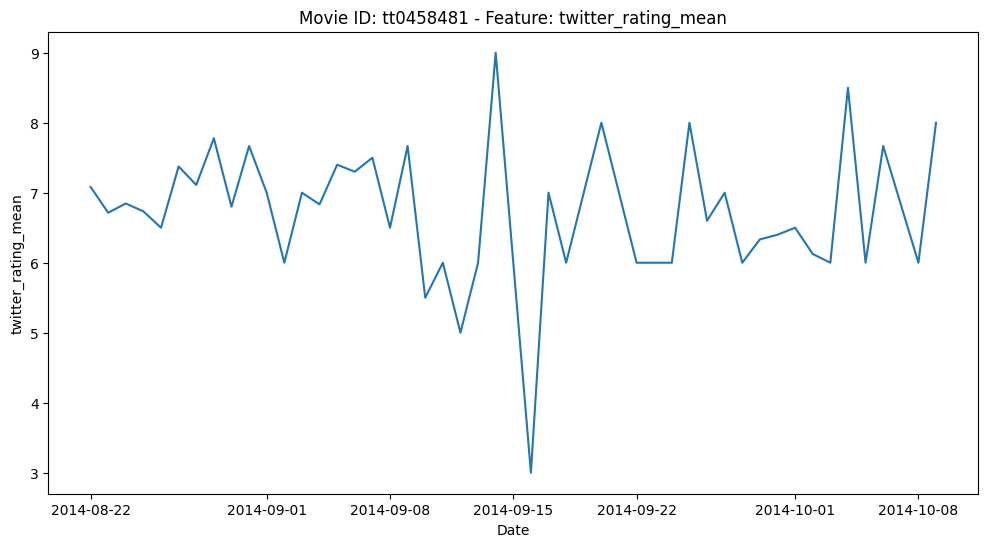

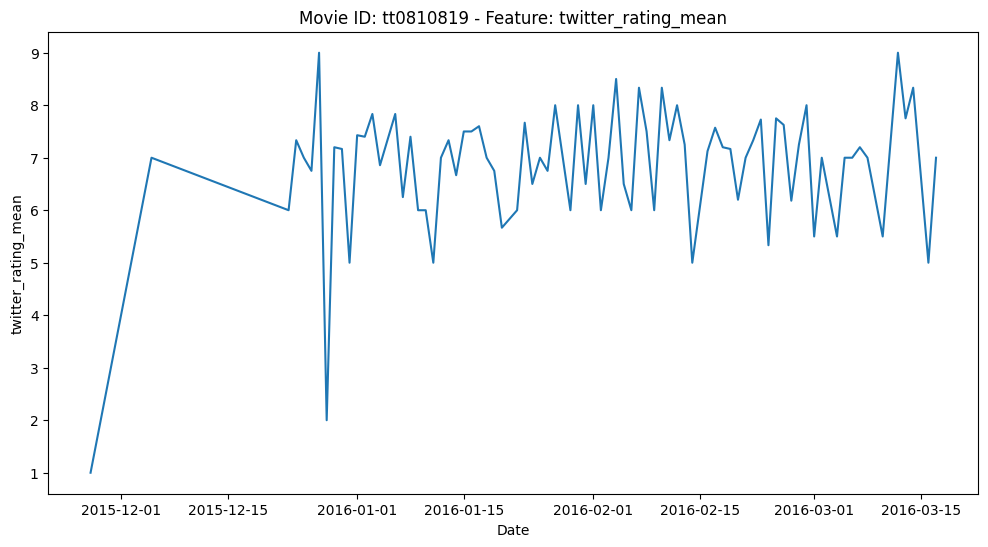

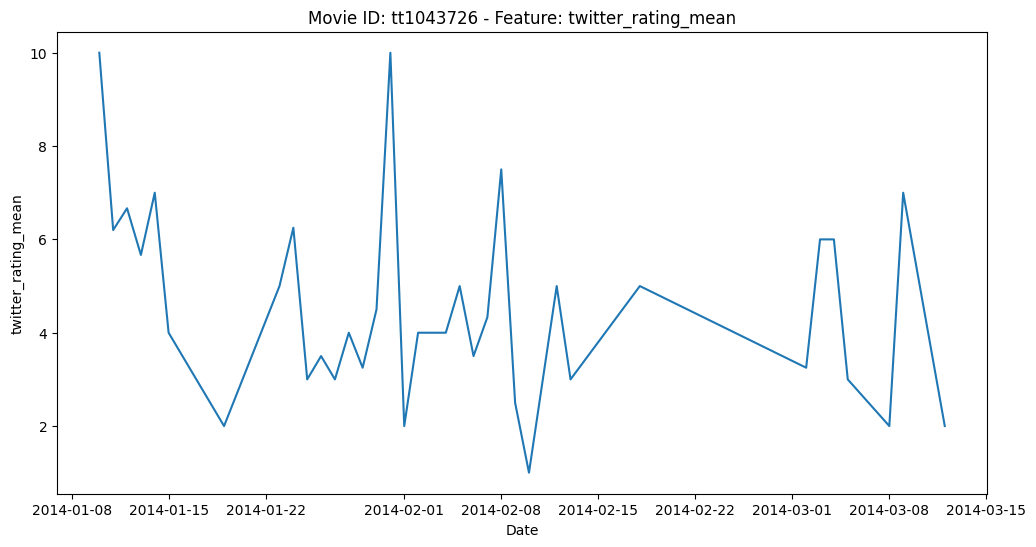

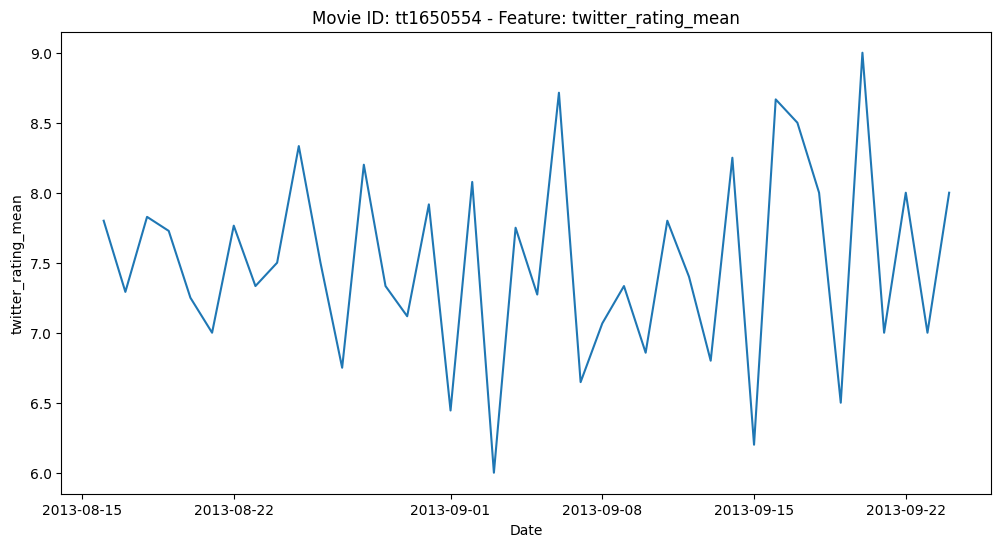

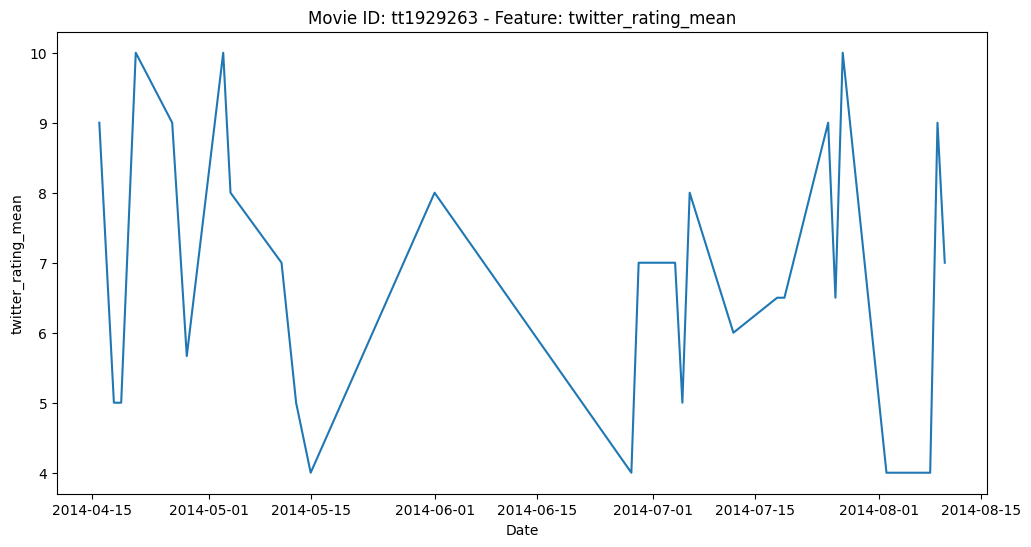

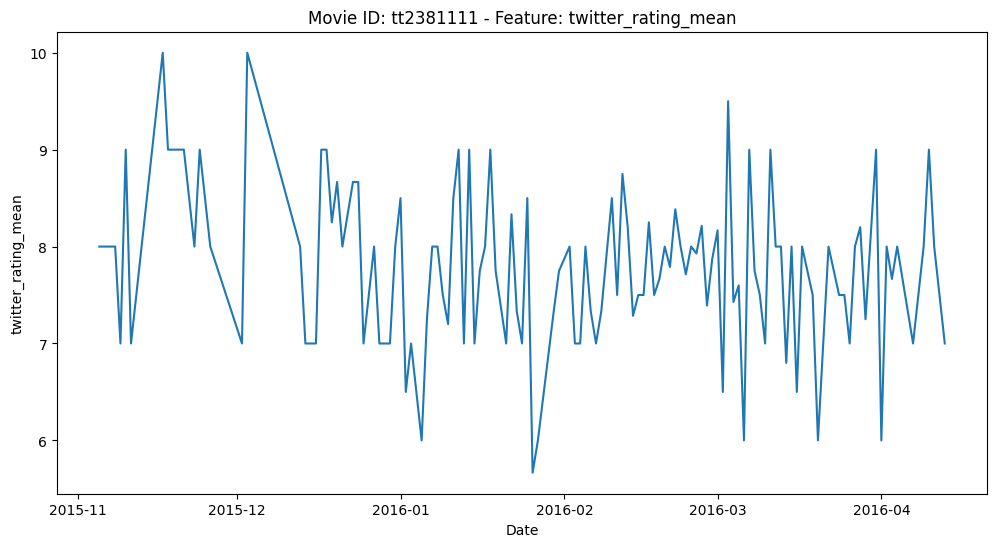

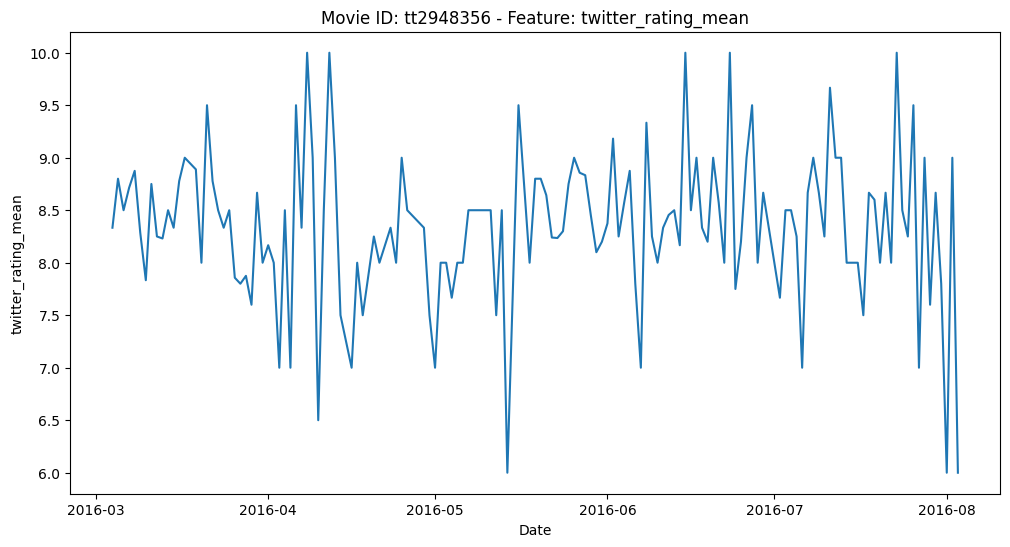

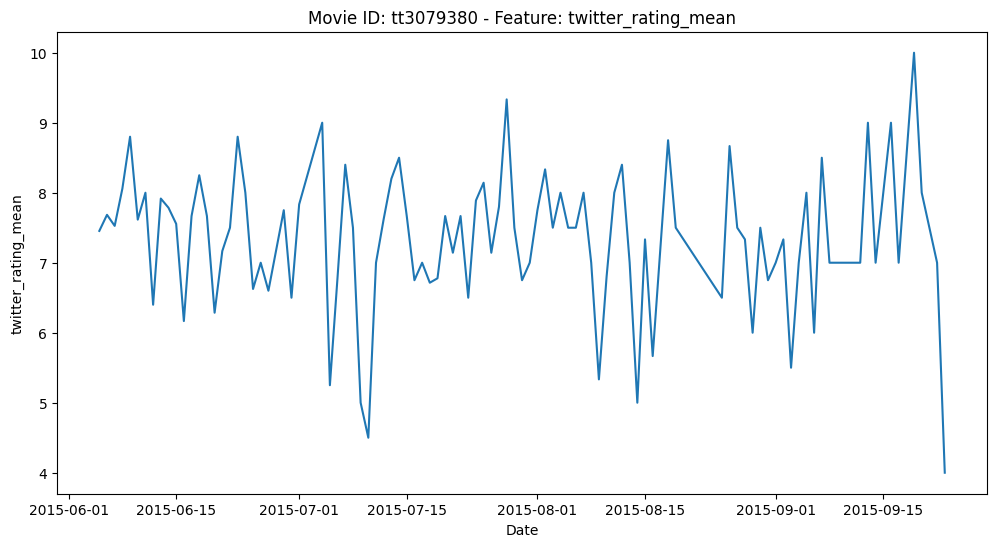

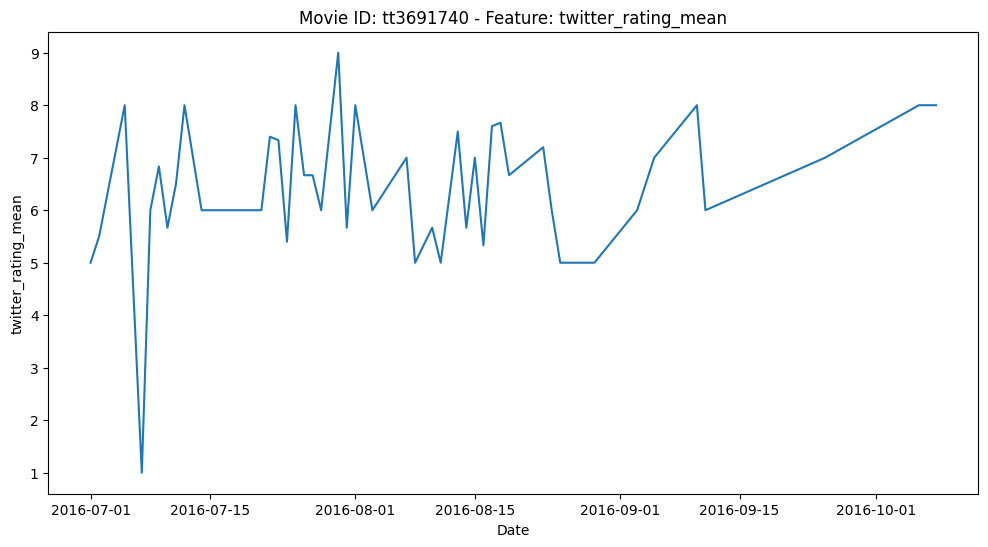

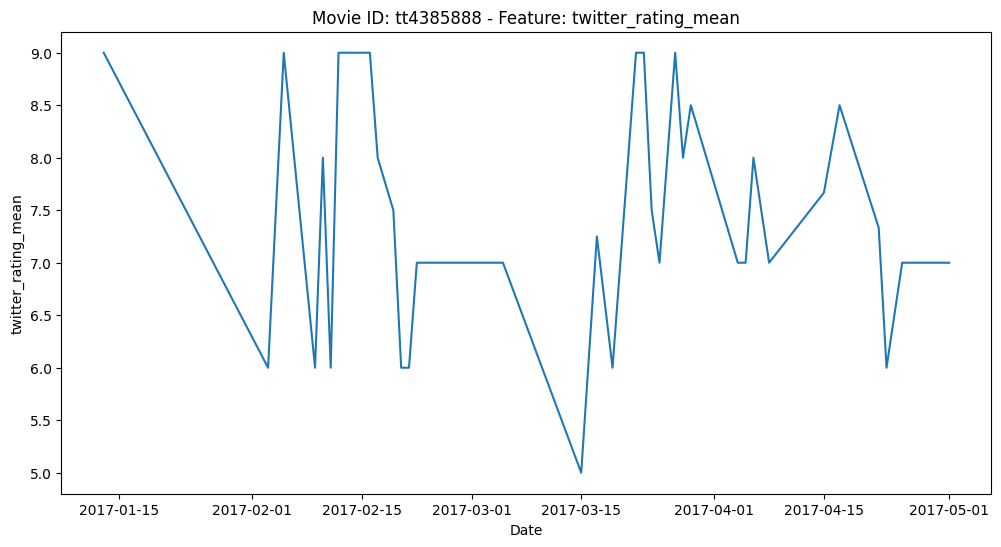

In [ ]:
# Plot time series for a specific feature
checker.plot_time_series_per_movie(feature='twitter_rating_mean')

Plot ACF and PACF


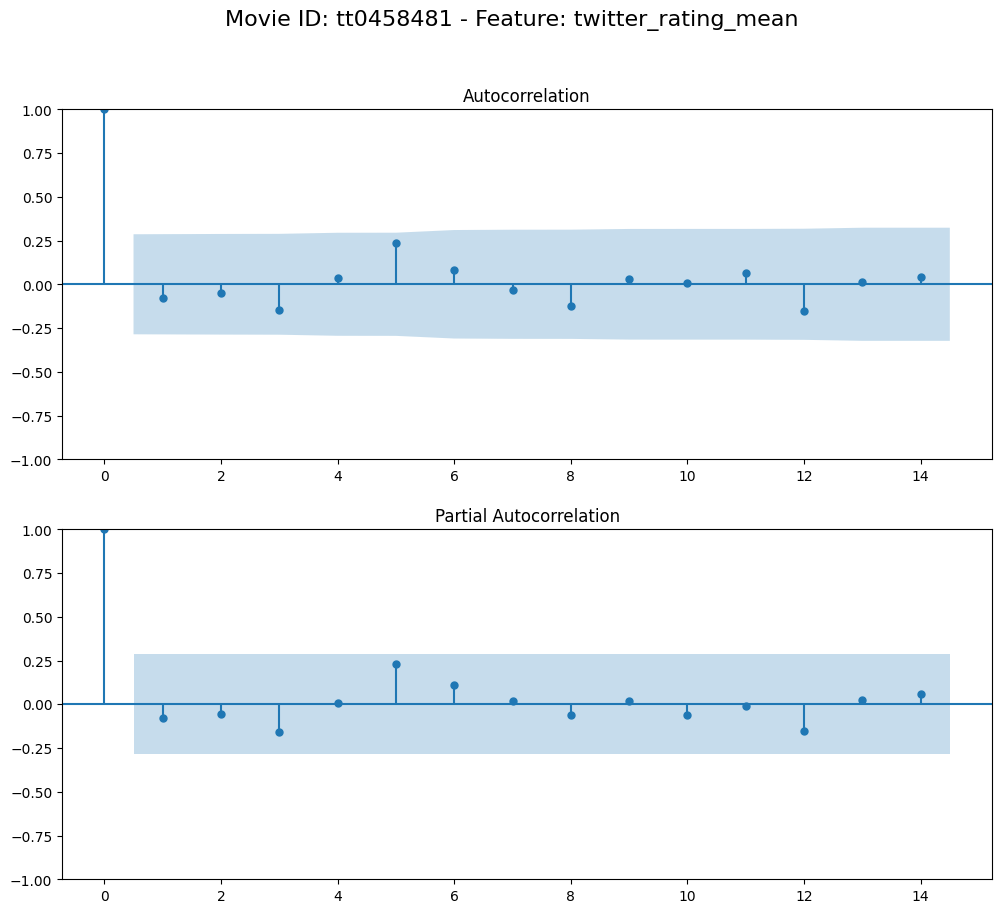

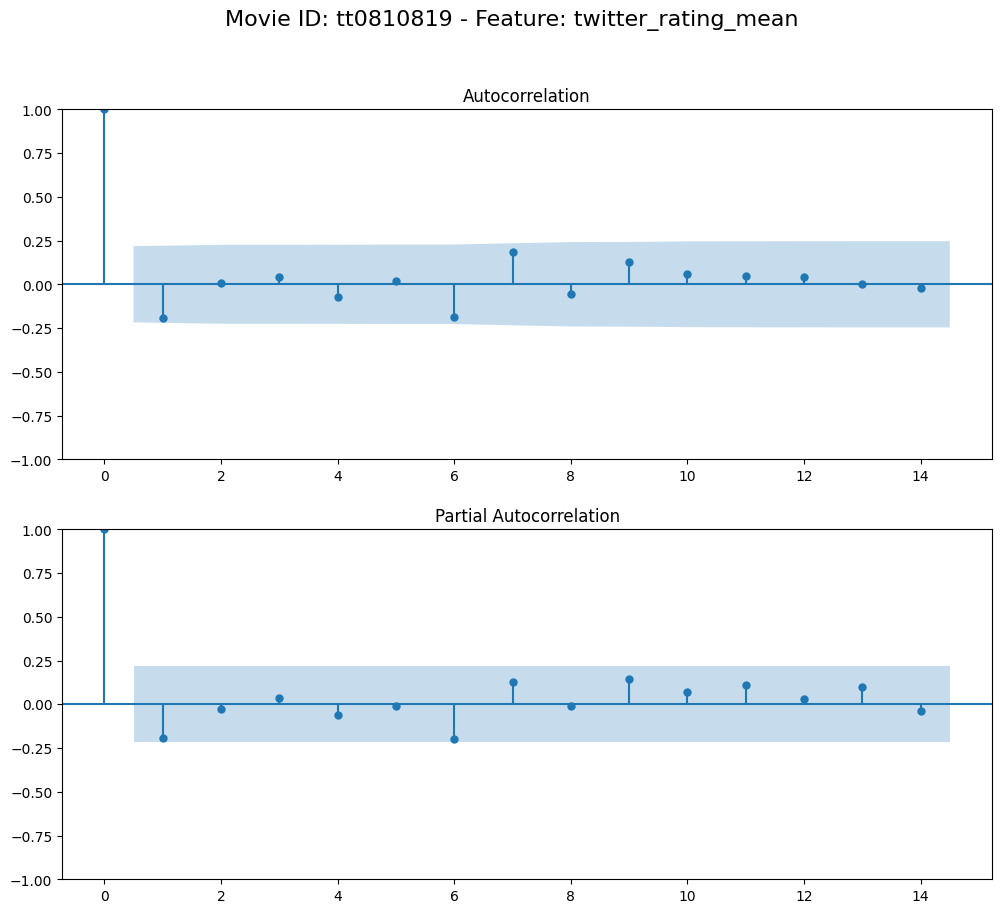

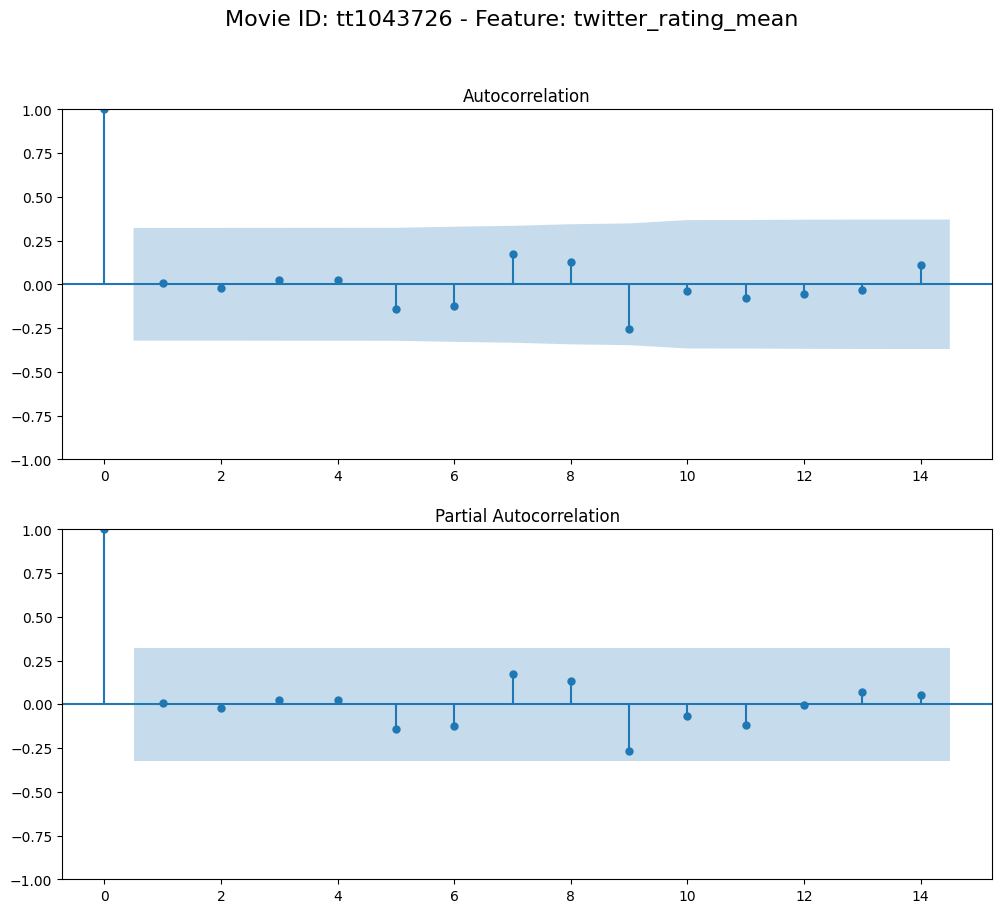

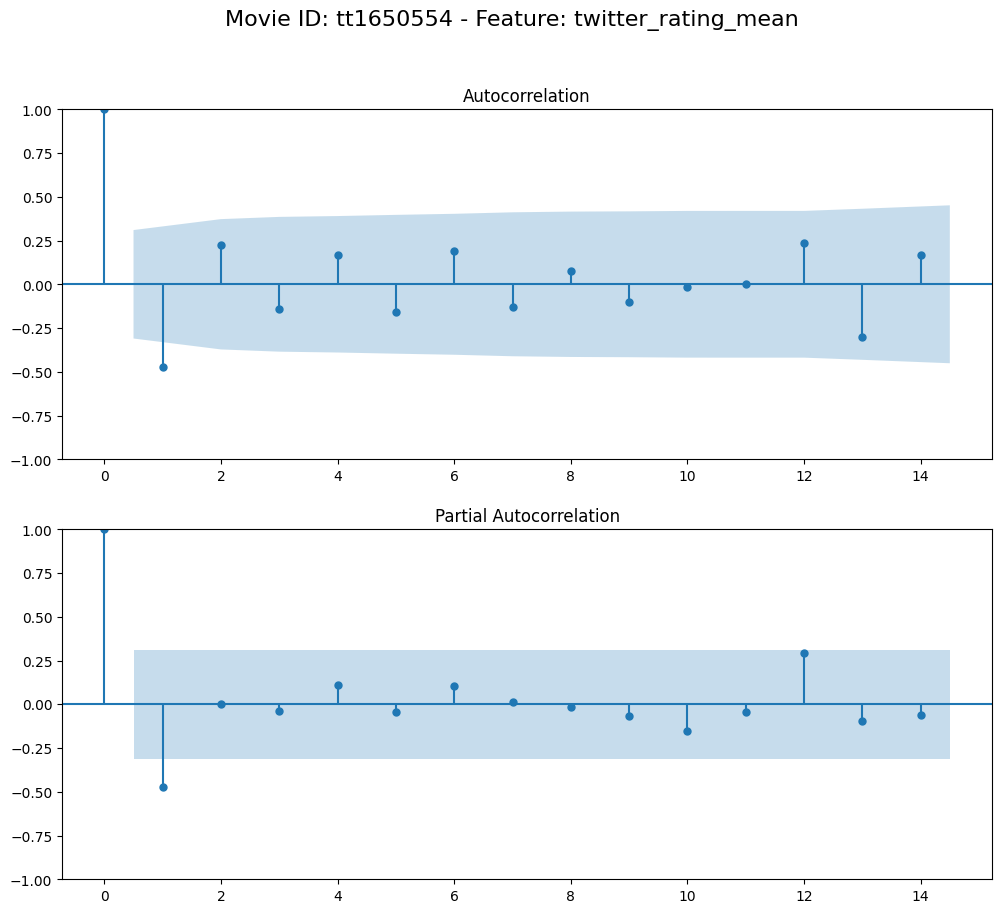

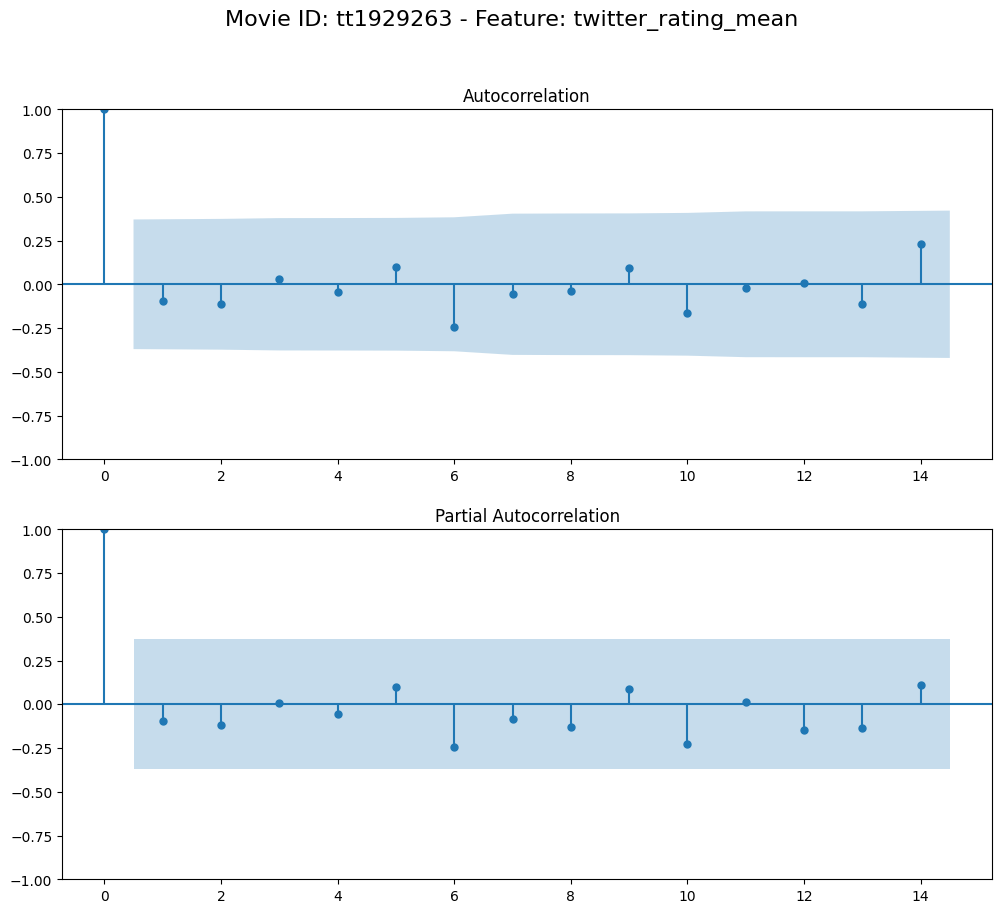

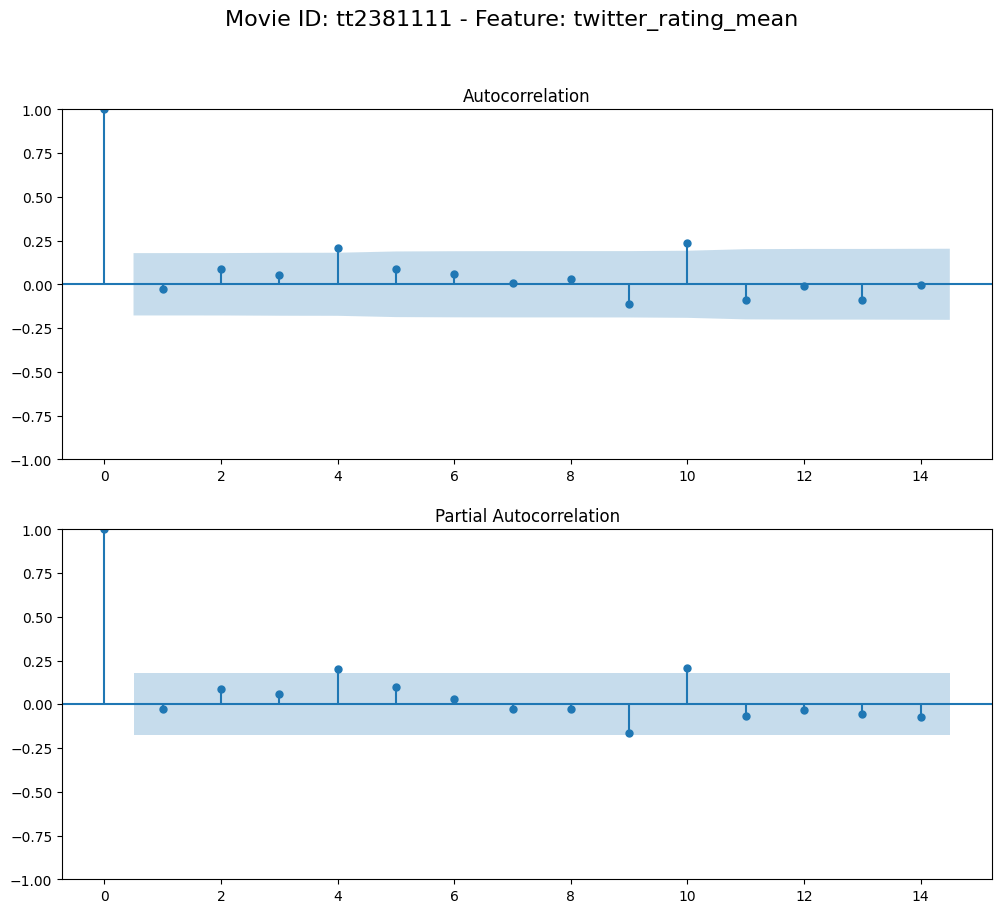

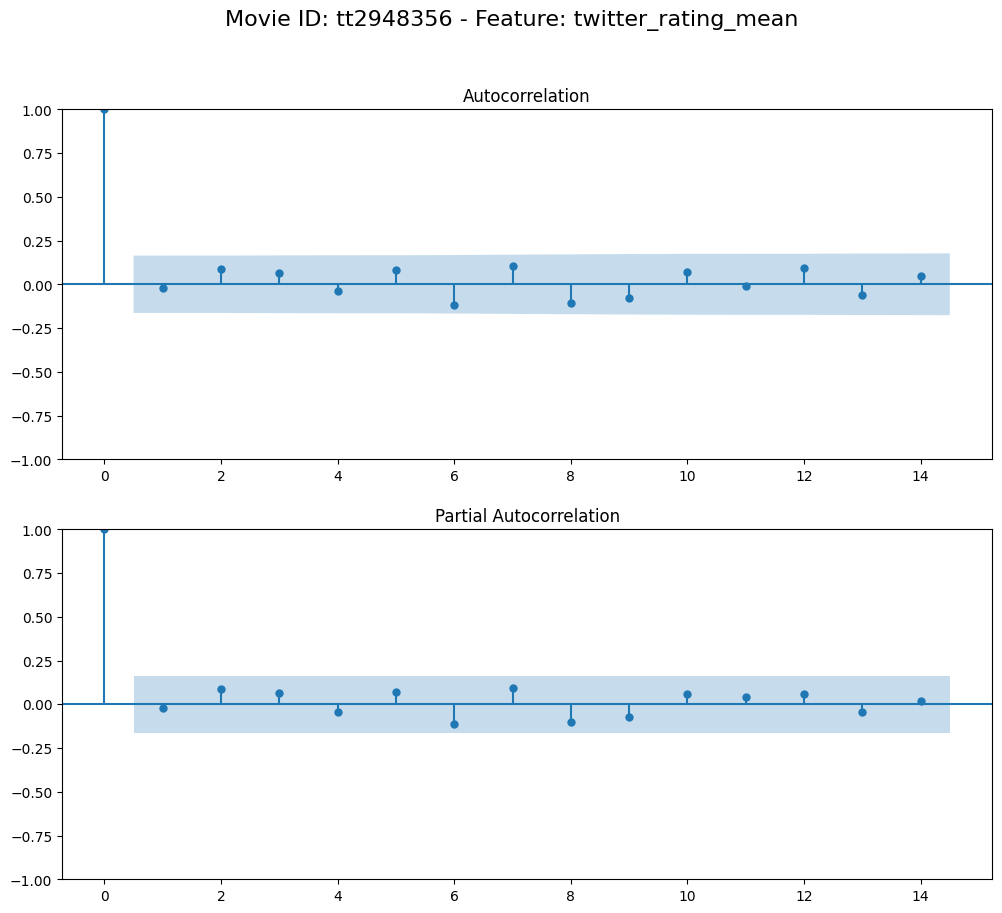

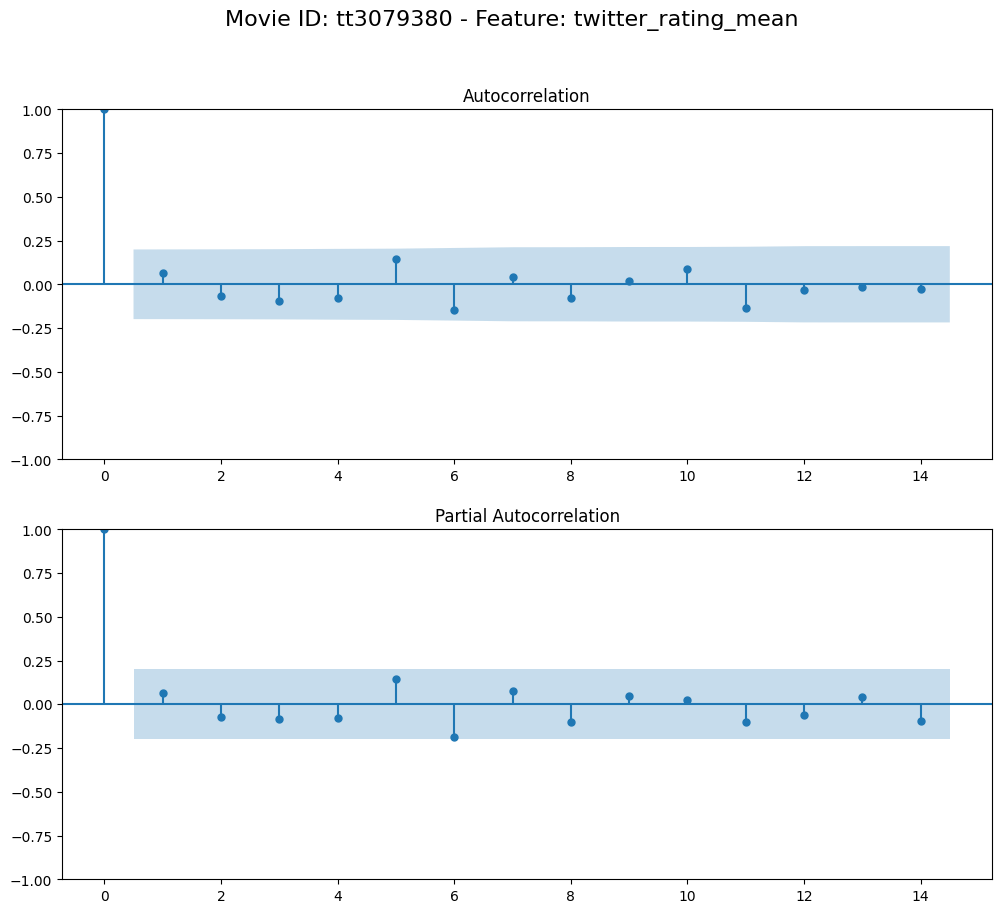

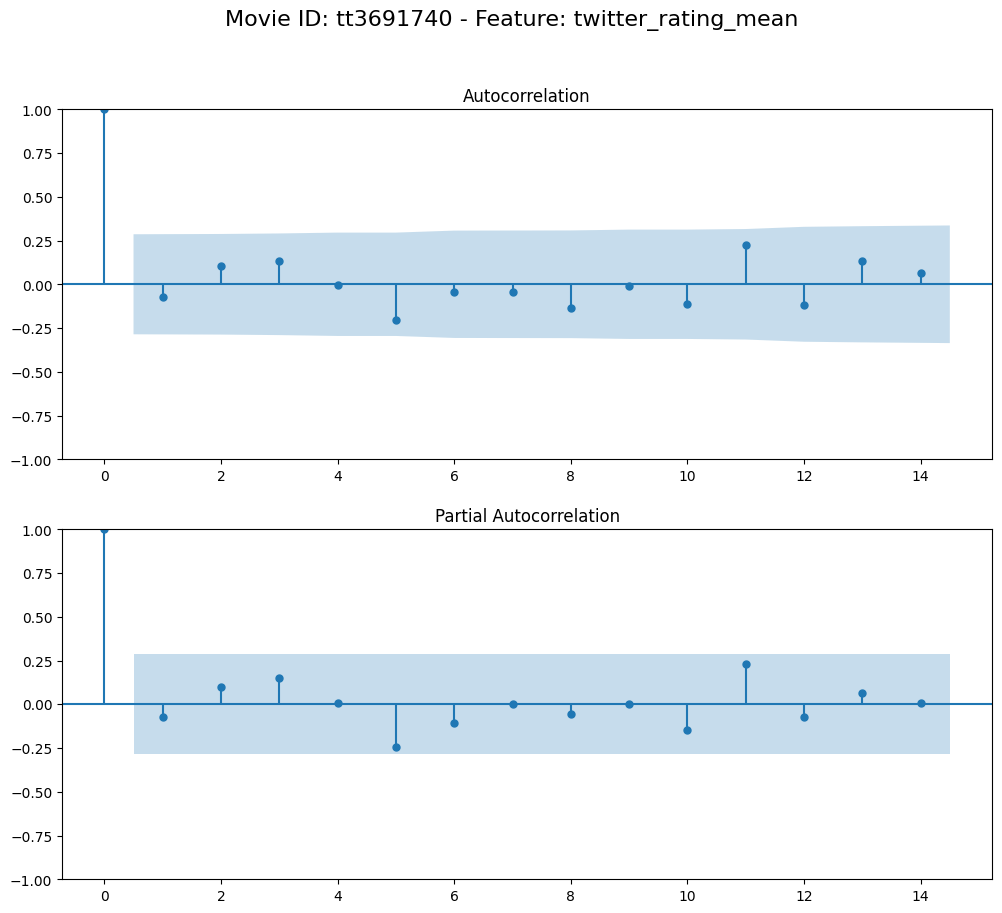

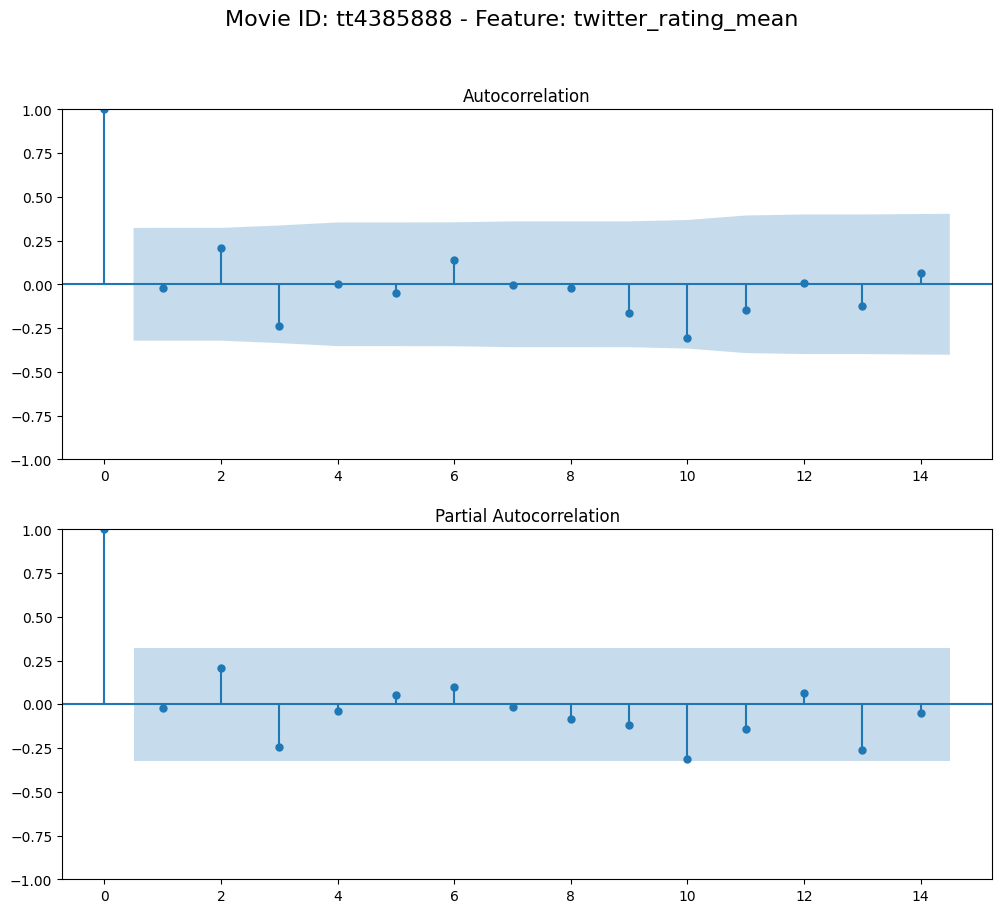

In [ ]:
# Plot ACF and PACF for a specific feature
checker.plot_acf_pacf_per_movie(feature='twitter_rating_mean', lags=14)

Decompose Time Series

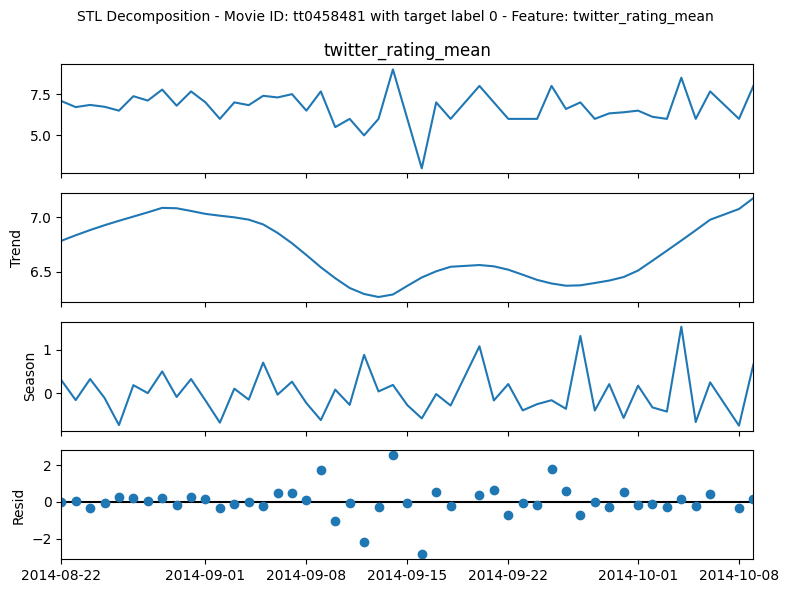

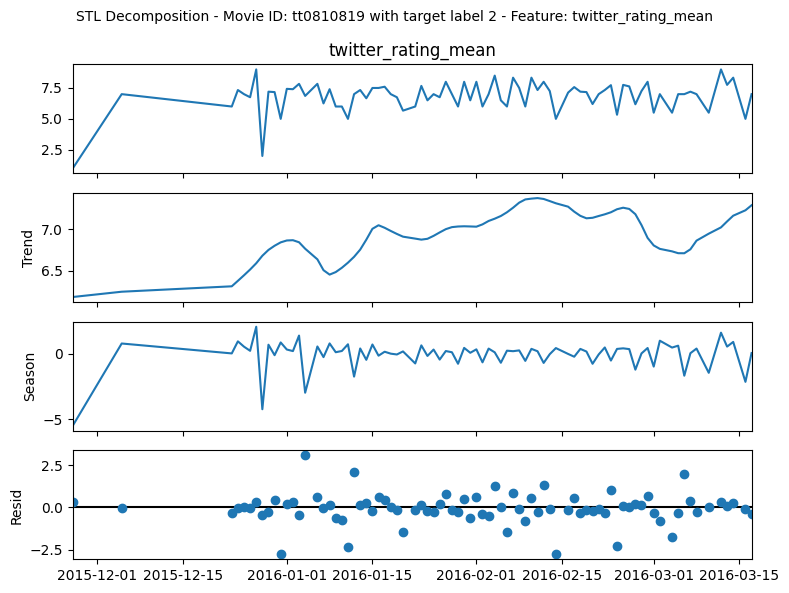

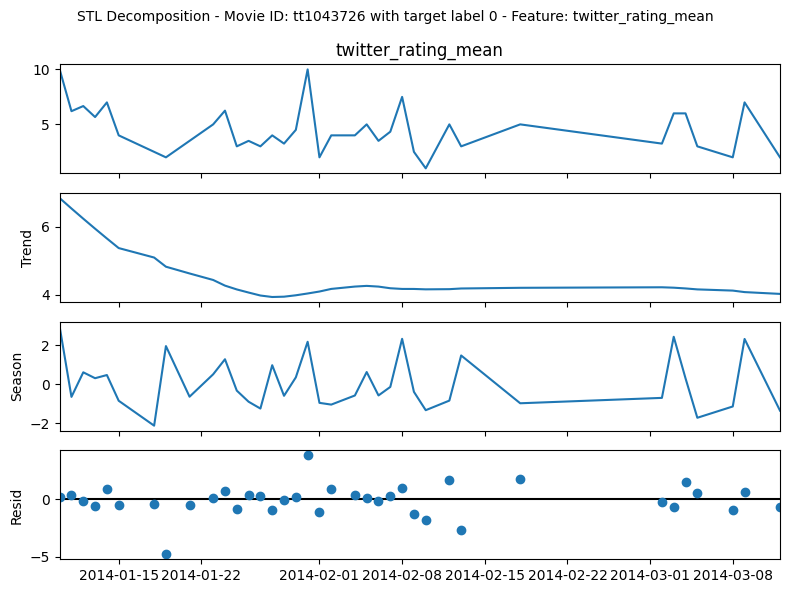

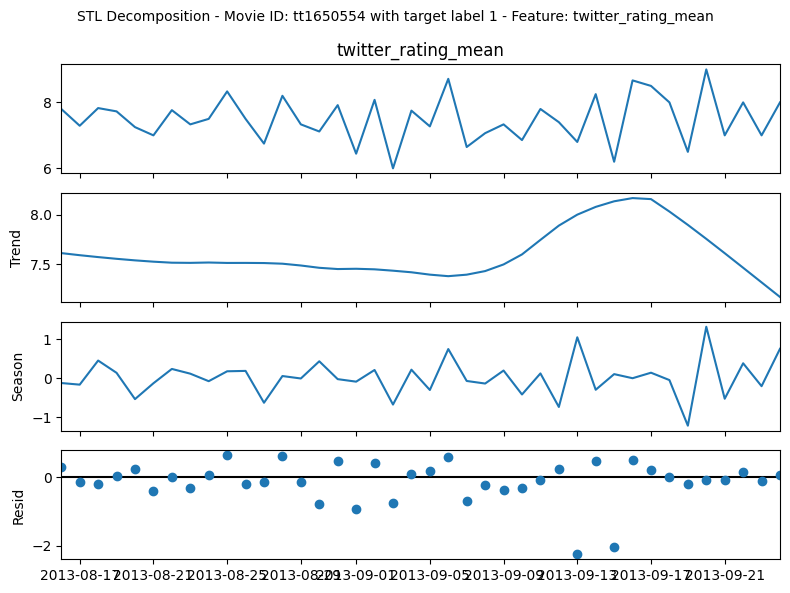

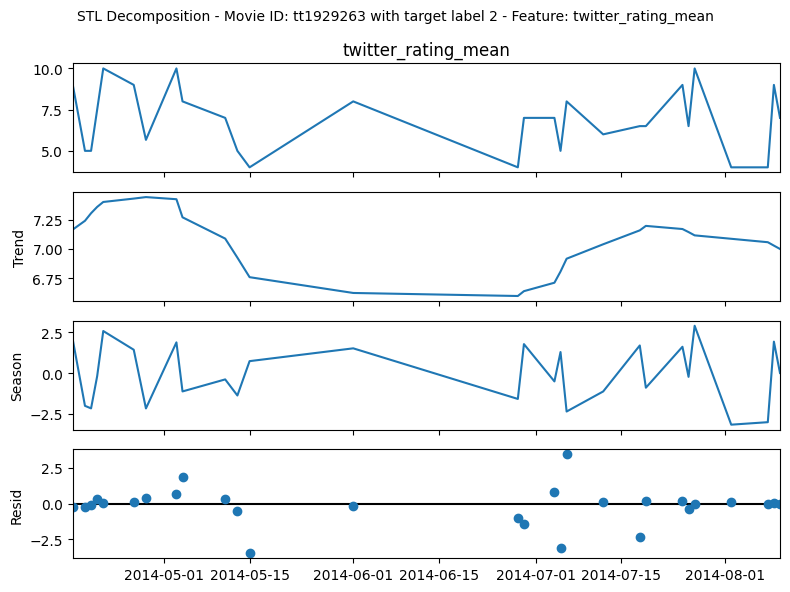

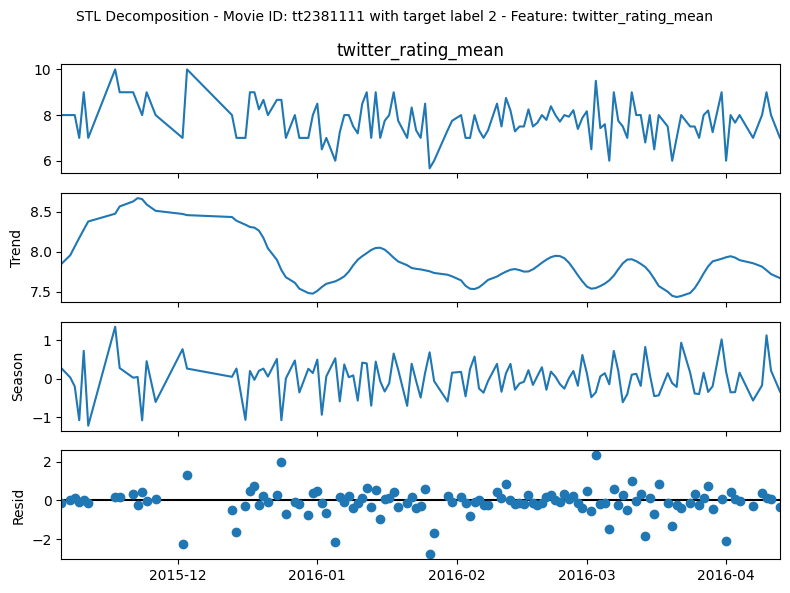

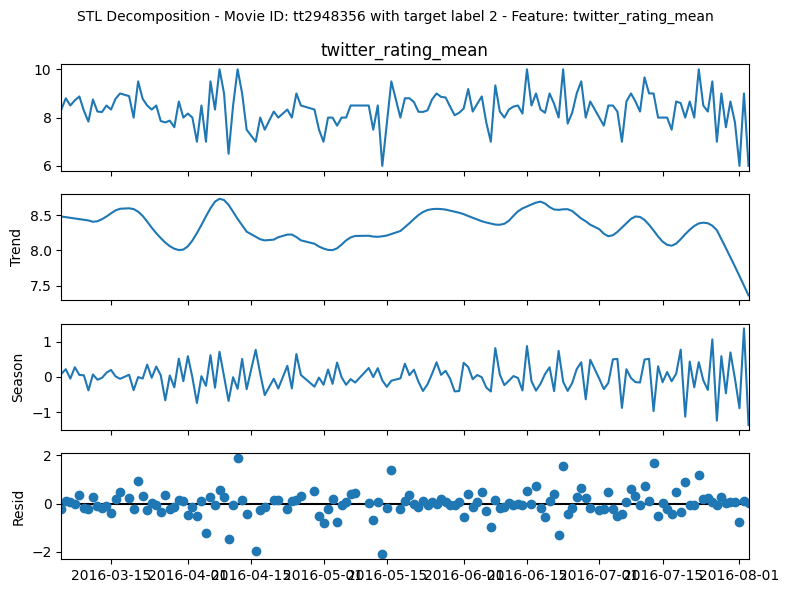

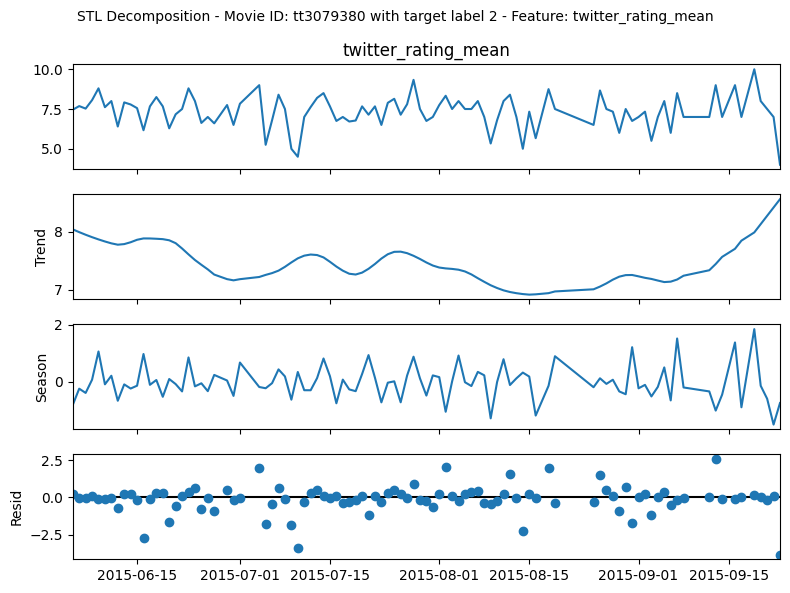

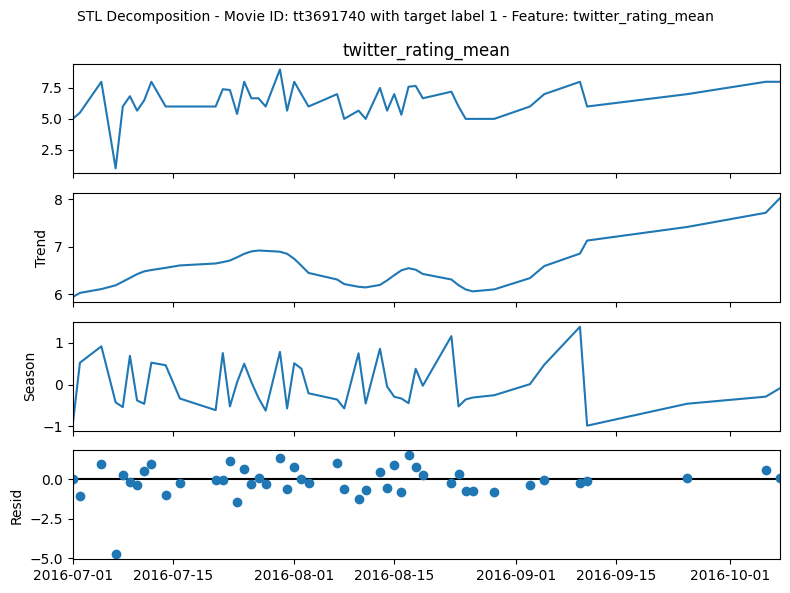

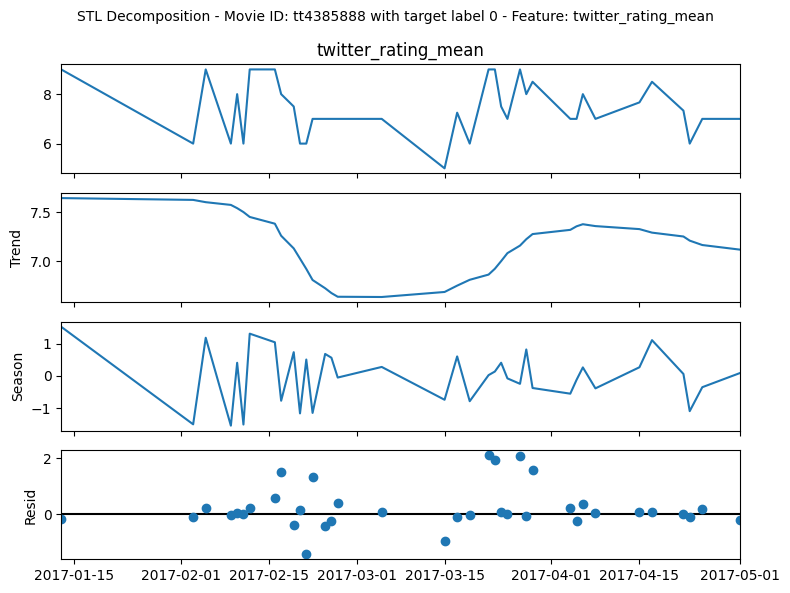

In [ ]:
# Perform STL decomposition for a specific feature
checker.decompose_time_series_per_movie(feature='twitter_rating_mean', period=7)

#### Feature Extraction

In [ ]:
import pandas as pd
from scipy.stats import linregress
import numpy as np

class TemporalFeatureExtractor:
    def __init__(self, data, feature, movieid_column, rating_date_column, fill_method='fill'):
        """
        Initializes the TemporalFeatureExtractor.

        Parameters:
        - data: The DataFrame containing the data.
        - feature: The column name for which the rolling window feature is to be extracted.
        - movieid_column: The column representing the unique identifier for each movie.
        - rating_date_column: The column representing the date for each rating, used for sorting.
        - fill_method: The method to handle missing values at the beginning of the rolling window.
                       Options are 'fill' for forward fill and '0-fill' to fill with zero.
        """
        self.data = data.sort_values(by=[movieid_column, rating_date_column]).copy()
        self.feature = feature
        self.movieid_column = movieid_column
        self.rating_date_column = rating_date_column
        self.fill_method = fill_method

    # 1 Rolling windows for different weeks
    def extract_feature(self, window_size):
        """
        Extracts the rolling window feature for a specified window size and appends it to the dataset, grouped by each movie.

        Parameters:
        - window_size: The size of the rolling window (integer) to be used for the current calculation.

        Returns:
        - Updated DataFrame with the new rolling feature added for the specified window size.
        """
        # Copy data to avoid modifying the original DataFrame
        data_copy = self.data.copy()

        # Generate the new column name based on feature and window size
        new_feature_name = f"{self.feature}_rolling_window_{window_size}_mean"

        # Calculate the rolling mean for the specified feature and window size, grouped by movie ID
        data_copy[new_feature_name] = (
            data_copy.groupby(self.movieid_column)[self.feature]
            .rolling(window=window_size)
            .mean()
            .reset_index(level=0, drop=True)
        )

        # Apply the fill method to handle NaN values from the rolling window
        if self.fill_method == 'fill':
            data_copy[new_feature_name].fillna(method='ffill', inplace=True)
        elif self.fill_method == '0-fill':
            data_copy[new_feature_name].fillna(0, inplace=True)
        else:
            raise ValueError("fill_method must be either 'fill' or '0-fill'")

        return data_copy

    # 2 the trend of the rolling mean
    def calculate_rolling_mean_trend(self, trend_window=7):
        """
        Calculates the trend of the rolling mean over a specified window for each movie.

        Parameters:
        - trend_window: The size of the window (in days) for the rolling mean.

        Returns:
        - DataFrame with rolling mean trend (slope) added for each movie.
        """
        def rolling_mean_slope(group):
            # Calculate rolling mean for the specified window
            rolling_mean = group[self.feature].rolling(window=trend_window, min_periods=1).mean()

            # Perform linear regression on the rolling mean
            x = np.arange(len(rolling_mean))
            if len(rolling_mean.dropna()) > 1:  # Ensure enough points for regression
                slope, _, _, _, _ = linregress(x, rolling_mean.fillna(method='ffill'))  # Forward fill for initial NaNs
                return slope
            else:
                return np.nan

        # Apply rolling mean slope calculation within each movie group
        rolling_trend_slopes = self.data.groupby(self.movieid_column).apply(rolling_mean_slope)

        # Store the result back in the main DataFrame
        self.data[f'rolling_mean_trend_{trend_window}_days_{self.feature}'] = self.data[self.movieid_column].map(rolling_trend_slopes)
        return self.data

    # 3 slope of linear regression fit for each movie
    def calculate_slope(self):
        """
        Calculates the slope of a linear regression fit for each movie.

        Returns:
        - DataFrame with slopes added.
        """
        def movie_slope(group):
            x = group['days_since_first_rating']
            y = group[self.feature]
            if len(x) > 1:  # Need at least 2 points for slope
                slope, _, _, _, _ = linregress(x, y)
                return slope
            else:
                return np.nan

        slopes = self.data.groupby(self.movieid_column).apply(movie_slope)
        self.data['slope_of_' + self.feature] = self.data[self.movieid_column].map(slopes)
        return self.data

    # 4 mean day over day difference
    def calculate_mean_difference(self):
        """
        Calculates the mean day-over-day difference for each movie.

        Returns:
        - DataFrame with mean day-over-day differences added.
        """
        self.data['day_diff'] = self.data.groupby(self.movieid_column)[self.feature].diff()
        mean_diff = self.data.groupby(self.movieid_column)['day_diff'].mean()
        self.data['mean_diff_' + self.feature] = self.data[self.movieid_column].map(mean_diff)
        self.data.drop(columns=['day_diff'], inplace=True)  # Clean up temporary column
        return self.data

    # 5 Lagged correlation
    def calculate_lagged_correlation(self, lag=1):
        """
        Calculates the correlation between the feature and its lagged values for each movie.

        Parameters:
        - lag: The number of days for the lagged correlation.

        Returns:
        - DataFrame with lagged correlation added.
        """
        def lagged_corr(group):
            return group[self.feature].corr(group[self.feature].shift(lag))

        lag_corr = self.data.groupby(self.movieid_column).apply(lagged_corr)
        self.data[f'lagged_corr_{str(lag)}_{self.feature}'] = self.data[self.movieid_column].map(lag_corr)
        return self.data

    # 6 autocorrelation for each movie
    def calculate_autocorrelation(self, lag=1):
        """
        Calculates the autocorrelation for each movie, handling cases with insufficient data,
        constant values, or missing data within groups.

        Parameters:
        - lag: The number of days for the autocorrelation.

        Returns:
        - DataFrame with autocorrelation added.
        """
        def autocorr_if_valid(x):
            # Drop missing values for accurate calculation
            x = x.dropna()

            # Check if there are enough data points after dropping NaNs
            if len(x) <= lag:
                return np.nan

            # Check if all values are constant (no variation)
            if x.nunique() == 1:
                return np.nan

            # Calculate autocorrelation if valid
            return x.autocorr(lag)

        # Apply the autocorrelation function within each movie group
        autocorrs = self.data.groupby(self.movieid_column)[self.feature].apply(autocorr_if_valid)
        self.data[f'autocorr_lag_{str(lag)}_{self.feature}'] = self.data[self.movieid_column].map(autocorrs)
        return self.data

    # 7  time to peak and trough
    def calculate_time_to_peak_trough(self):
        """
        Calculates time to peak and trough for each movie using the date column.

        Returns:
        - DataFrame with time to peak and trough added based on the date of each peak/trough.
        """
        def time_to_peak_trough(group):
            # Find the date of the first review
            first_date = group[self.rating_date_column].min()

            # Find the peak and trough dates
            peak_date = group.loc[group[self.feature].idxmax(), self.rating_date_column]
            trough_date = group.loc[group[self.feature].idxmin(), self.rating_date_column]

            # Calculate the time difference in days between first date and peak/trough dates
            time_to_peak = (peak_date - first_date).days
            time_to_trough = (trough_date - first_date).days

            return pd.Series({'time_to_peak': time_to_peak, 'time_to_trough': time_to_trough})

        # Apply the function within each group
        peak_trough_times = self.data.groupby(self.movieid_column).apply(time_to_peak_trough)

        # Merge results back into the main DataFrame
        self.data = self.data.join(peak_trough_times, on=self.movieid_column)

        # Rename columns to align with the feature name
        self.data.rename(columns={
            'time_to_peak': 'time_to_peak_' + self.feature,
            'time_to_trough': 'time_to_trough_' + self.feature
        }, inplace=True)

        return self.data

    # 8 longest rising/falling streaks
    def calculate_streaks(self):
        """
        Calculates the duration of longest rising/falling streaks for each movie.

        Returns:
        - DataFrame with streaks added.
        """
        def longest_streak(series, direction='increase'):
            streak = max_streak = 0
            for i in range(1, len(series)):
                if (series.iloc[i] > series.iloc[i - 1] and direction == 'increase') or \
                   (series.iloc[i] < series.iloc[i - 1] and direction == 'decrease'):
                    streak += 1
                    max_streak = max(max_streak, streak)
                else:
                    streak = 0
            return max_streak

        increase_streaks = self.data.groupby(self.movieid_column)[self.feature].apply(longest_streak, direction='increase')
        decrease_streaks = self.data.groupby(self.movieid_column)[self.feature].apply(longest_streak, direction='decrease')

        self.data['longest_increase_streak_' + self.feature] = self.data[self.movieid_column].map(increase_streaks)
        self.data['longest_decrease_streak_' + self.feature] = self.data[self.movieid_column].map(decrease_streaks)
        return self.data


In [ ]:
cols_to_keep = chosen_features
print(cols_to_keep)

['twitter_rating_mean', 'twitter_rating_min', 'twitter_rating_max', 'twitter_number_users', 'from_imdb_imdb_id', 'daily_box_office_date_revenue_recorded', 'daily_box_office_TotalBoxOffice_lifespan', 'daily_box_office_DailyBoxOfficeRevenue', 'daily_box_office_accumulated_DailyBoxOfficeRevenues_since_Realease', 'daily_box_office_%± YD gross change daily', 'daily_box_office_%± LW gross change weekly', 'daily_box_office_per theaters avg gross', 'daily_box_office_Theaters_cleaned', 'Success_Label', 'days_after_release', 'days_since_first_rating', 'days_between_first_and_last_rating']


In [ ]:
# Prepare your dataset
dataset_rolling = dataset.copy()
dataset_rolling = dataset_rolling[cols_to_keep]
dataset_rolling.reset_index(drop=True, inplace=True)

# Initialize the TemporalFeatureExtractor
extractor = TemporalFeatureExtractor(
    data=dataset_rolling,
    feature='twitter_rating_mean',
    movieid_column='from_imdb_imdb_id',
    rating_date_column='daily_box_office_date_revenue_recorded',
    fill_method='fill'
)

# 1. Extract rolling window means with different window sizes (e.g., 7, 14, 21, 28 days)
window_sizes = [7, 14, 21, 28]
for window_size in window_sizes:
    data_with_rolling = extractor.extract_feature(window_size=window_size)
    print(f"\nRolling window mean feature added for window size {window_size}:\n", data_with_rolling)

# 2. Calculate the rolling mean trend for a specified trend window (e.g., 7 days)
trend_window = 7
data_with_trend = extractor.calculate_rolling_mean_trend(trend_window=trend_window)
print(f"\nRolling mean trend feature added for trend window {trend_window} days:\n", data_with_trend)

# 3. Calculate the slope of a linear fit for each movie
data_with_slope = extractor.calculate_slope()
print("\nSlope of linear fit feature added:\n", data_with_slope)

# 4. Calculate the mean difference (day-over-day change)
data_with_mean_diff = extractor.calculate_mean_difference()
print("\nMean difference feature added:\n", data_with_mean_diff)

# 5. Calculate lagged correlation (e.g., with lag=1)
lag = 1
data_with_lagged_corr = extractor.calculate_lagged_correlation(lag=lag)
print(f"\nLagged correlation feature added with lag {lag}:\n", data_with_lagged_corr)

# 6. Calculate autocorrelation (e.g., with lag=1)
data_with_autocorr = extractor.calculate_autocorrelation(lag=lag)
print(f"\nAutocorrelation feature added with lag {lag}:\n", data_with_autocorr)

# 7. Calculate time to peak and trough for each movie
data_with_peak_trough = extractor.calculate_time_to_peak_trough()
print("\nTime to peak and trough feature added:\n", data_with_peak_trough)

# 8. Calculate the longest rising/falling streaks
data_with_streaks = extractor.calculate_streaks()
print("\nLongest rising/falling streaks added:\n", data_with_streaks)



Rolling window mean feature added for window size 7:
        twitter_rating_mean  twitter_rating_min  twitter_rating_max  \
0                 7.700000                   6                  10   
1                 7.111111                   4                   9   
2                 7.454545                   3                  10   
3                 7.875000                   4                  10   
4                 8.235294                   6                  10   
...                    ...                 ...                 ...   
26843             9.000000                   9                   9   
26844             6.000000                   6                   6   
26845             5.000000                   5                   5   
26846             6.500000                   6                   7   
26847             7.000000                   7                   7   

       twitter_number_users from_imdb_imdb_id  \
0                        10         tt0359950   
1     

<ipython-input-37-13fc4c8edbf8>:51: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_copy[new_feature_name].fillna(method='ffill', inplace=True)
<ipython-input-37-13fc4c8edbf8>:51: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_copy[new_feature_name].fillna(method='ffill', inplace=True)
<ipython-input-37-13fc4c8edbf8>:51: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an


Rolling mean trend feature added for trend window 7 days:
        twitter_rating_mean  twitter_rating_min  twitter_rating_max  \
0                 7.700000                   6                  10   
1                 7.111111                   4                   9   
2                 7.454545                   3                  10   
3                 7.875000                   4                  10   
4                 8.235294                   6                  10   
...                    ...                 ...                 ...   
26843             9.000000                   9                   9   
26844             6.000000                   6                   6   
26845             5.000000                   5                   5   
26846             6.500000                   6                   7   
26847             7.000000                   7                   7   

       twitter_number_users from_imdb_imdb_id  \
0                        10         tt0359950   
1

<ipython-input-37-13fc4c8edbf8>:138: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lag_corr = self.data.groupby(self.movieid_column).apply(lagged_corr)



Lagged correlation feature added with lag 1:
        twitter_rating_mean  twitter_rating_min  twitter_rating_max  \
0                 7.700000                   6                  10   
1                 7.111111                   4                   9   
2                 7.454545                   3                  10   
3                 7.875000                   4                  10   
4                 8.235294                   6                  10   
...                    ...                 ...                 ...   
26843             9.000000                   9                   9   
26844             6.000000                   6                   6   
26845             5.000000                   5                   5   
26846             6.500000                   6                   7   
26847             7.000000                   7                   7   

       twitter_number_users from_imdb_imdb_id  \
0                        10         tt0359950   
1             

<ipython-input-37-13fc4c8edbf8>:197: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  peak_trough_times = self.data.groupby(self.movieid_column).apply(time_to_peak_trough)



Time to peak and trough feature added:
        twitter_rating_mean  twitter_rating_min  twitter_rating_max  \
0                 7.700000                   6                  10   
1                 7.111111                   4                   9   
2                 7.454545                   3                  10   
3                 7.875000                   4                  10   
4                 8.235294                   6                  10   
...                    ...                 ...                 ...   
26843             9.000000                   9                   9   
26844             6.000000                   6                   6   
26845             5.000000                   5                   5   
26846             6.500000                   6                   7   
26847             7.000000                   7                   7   

       twitter_number_users from_imdb_imdb_id  \
0                        10         tt0359950   
1                   

In [ ]:
data_with_streaks.isna().sum()

,0
twitter_rating_mean,0
twitter_rating_min,0
twitter_rating_max,0
twitter_number_users,0
from_imdb_imdb_id,0
daily_box_office_date_revenue_recorded,0
daily_box_office_TotalBoxOffice_lifespan,0
daily_box_office_DailyBoxOfficeRevenue,0
daily_box_office_accumulated_DailyBoxOfficeRevenues_since_Realease,0
daily_box_office_%± YD gross change daily,0


Looking at the feature extraction, all of the features contain values for each sample.

Next, we will check if the extracted features are correct for time_to_peak_rotten_rating_sentiment_polarity_mean and time_to_trough_rotten_rating_sentiment_polarity_mean since they contain information we can compare with days_between_first_and_last_rating. They should be smaller or to a maximum equal to days_between_first_and_last_rating.

In [ ]:
print("Size 'time_to_peak_twitter_rating_mean' invalid rows: ",data_with_streaks[data_with_streaks["time_to_peak_twitter_rating_mean"] > data_with_streaks["days_between_first_and_last_rating"]].shape)
print("Size 'time_to_trough_twitter_rating_mean' invalid rows: ",data_with_streaks[data_with_streaks["time_to_trough_twitter_rating_mean"] > data_with_streaks["days_between_first_and_last_rating"]].shape)


Size 'time_to_peak_twitter_rating_mean' invalid rows:  (0, 26)
Size 'time_to_trough_twitter_rating_mean' invalid rows:  (0, 26)


Check for the derived features, how many unique values they contain.

In [ ]:
# check number unique values per feature
print("Shape of dataset")
print(f"{'-' * len('Shape of dataset') }")
print("Size of dataset", data_with_streaks.shape)

print("\n\nNumber unique movies in dataset")
print(f"{'-' * len('Number unique movies in dataset') }" )
print("Size of dataset", data_with_streaks["from_imdb_imdb_id"].unique().shape)

print("\n\nCheck unique vals:")
print(f"{'-' * len('Check unique vals:') }")
for col in data_with_streaks.columns:
    if col not in cols_to_keep:
        print(col,"\t", data_with_streaks[col].unique().shape)

Shape of dataset
----------------
Size of dataset (26848, 26)


Number unique movies in dataset
-------------------------------
Size of dataset (393,)


Check unique vals:
------------------
rolling_mean_trend_7_days_twitter_rating_mean 	 (393,)
slope_of_twitter_rating_mean 	 (393,)
mean_diff_twitter_rating_mean 	 (354,)
lagged_corr_1_twitter_rating_mean 	 (393,)
autocorr_lag_1_twitter_rating_mean 	 (393,)
time_to_peak_twitter_rating_mean 	 (97,)
time_to_trough_twitter_rating_mean 	 (118,)
longest_increase_streak_twitter_rating_mean 	 (5,)
longest_decrease_streak_twitter_rating_mean 	 (5,)


The dataset with additional extracted temproal features contains 166,136 records across 3,033 unique movies, with several metrics that capture trends in movie sentiment ratings over time. Most features, such as rolling_mean_trend_7_days_rotten_rating_sentiment_polarity_mean and slope_of_rotten_rating_sentiment_polarity_mean, have 3,033 unique values, suggesting they are calculated individually for each movie. However, certain columns, like time_to_peak_rotten_rating_sentiment_polarity_mean and time_to_trough_rotten_rating_sentiment_polarity_mean, have fewer unique values (1,526 and 1,472), likely indicating that not all movies reach a peak or trough within the observed timeframe. For the streak-related columns (longest_increase_streak_rotten_rating_sentiment_polarity_mean and longest_decrease_streak_rotten_rating_sentiment_polarity_mean), only 8 and 7 unique values are present, respectively, which could imply that most movies exhibit similar patterns in streak length. This clustering may reflect common trends or seasonality in sentiment changes across movies. However, if more variation in streak lengths was anticipated, a review of the streak calculation logic may be warranted to ensure it captures the expected diversity in movie performance over time.

##### Detailed investigation of streaks values

In [ ]:
print("Shape longest_decrease_streak_twitter_rating_mean: ", data_with_streaks["longest_decrease_streak_twitter_rating_mean"].unique().shape)
print("Unique values: ", sorted(data_with_streaks["longest_decrease_streak_twitter_rating_mean"].unique()))

data_with_streaks_movies = data_with_streaks[["from_imdb_imdb_id", "longest_decrease_streak_twitter_rating_mean"]].drop_duplicates()
data_with_streaks_movies_grouped = data_with_streaks_movies.groupby("from_imdb_imdb_id").agg(Number_unique_longest_decrease_streak_twitter_rating_mean = ("longest_decrease_streak_twitter_rating_mean", "nunique")).reset_index()
print("Number movies: ", data_with_streaks_movies_grouped["from_imdb_imdb_id"].unique().shape)
print("Number movies with more than one streak value recorded: ", data_with_streaks_movies_grouped[data_with_streaks_movies_grouped["Number_unique_longest_decrease_streak_twitter_rating_mean"] > 1].shape)
print("Number movies with less than one streak value recorded: ", data_with_streaks_movies_grouped[data_with_streaks_movies_grouped["Number_unique_longest_decrease_streak_twitter_rating_mean"] <= 1].shape)

for i in sorted(data_with_streaks["longest_decrease_streak_twitter_rating_mean"].unique()):
    print("Number movies with a streak equal to ", i, ": ", data_with_streaks_movies[data_with_streaks_movies["longest_decrease_streak_twitter_rating_mean"] == i].shape)


Shape longest_decrease_streak_twitter_rating_mean:  (5,)
Unique values:  [1, 2, 3, 4, 5]
Number movies:  (393,)
Number movies with more than one streak value recorded:  (0, 2)
Number movies with less than one streak value recorded:  (393, 2)
Number movies with a streak equal to  1 :  (1, 2)
Number movies with a streak equal to  2 :  (75, 2)
Number movies with a streak equal to  3 :  (236, 2)
Number movies with a streak equal to  4 :  (67, 2)
Number movies with a streak equal to  5 :  (14, 2)


In [ ]:
print("Shape longest_increase_streak_from_imdb_daily_mean_rating: ", data_with_streaks["longest_increase_streak_twitter_rating_mean"].unique().shape)
print("Unique values: ", sorted(data_with_streaks["longest_increase_streak_twitter_rating_mean"].unique()))

data_with_streaks_movies = data_with_streaks[["from_imdb_imdb_id", "longest_increase_streak_twitter_rating_mean"]].drop_duplicates()
data_with_streaks_movies_grouped = data_with_streaks_movies.groupby("from_imdb_imdb_id").agg(Number_unique_longest_increase_streak_twitter_rating_mean = ("longest_increase_streak_twitter_rating_mean", "nunique")).reset_index()
print("Number movies: ", data_with_streaks_movies_grouped["from_imdb_imdb_id"].unique().shape)
print("Number movies with more than one unique streak value recorded: ", data_with_streaks_movies_grouped[data_with_streaks_movies_grouped["Number_unique_longest_increase_streak_twitter_rating_mean"] > 1].shape)
print("Number movies with less than one unique streak value recorded: ", data_with_streaks_movies_grouped[data_with_streaks_movies_grouped["Number_unique_longest_increase_streak_twitter_rating_mean"] <= 1].shape)

for i in sorted(data_with_streaks["longest_increase_streak_twitter_rating_mean"].unique()):
    print("Number movies with a streak equal to ", i, ": ", data_with_streaks_movies[data_with_streaks_movies["longest_increase_streak_twitter_rating_mean"] == i].shape)


Shape longest_increase_streak_from_imdb_daily_mean_rating:  (5,)
Unique values:  [1, 2, 3, 4, 5]
Number movies:  (393,)
Number movies with more than one unique streak value recorded:  (0, 2)
Number movies with less than one unique streak value recorded:  (393, 2)
Number movies with a streak equal to  1 :  (1, 2)
Number movies with a streak equal to  2 :  (107, 2)
Number movies with a streak equal to  3 :  (205, 2)
Number movies with a streak equal to  4 :  (69, 2)
Number movies with a streak equal to  5 :  (11, 2)


For the longest_decrease_streak_rotten_rating_sentiment_polarity_mean, there are only 7 unique streak values (from 1 to 7), with most movies showing streaks of 3 (1,545 movies) and 2 (704 movies). This clustering around low streak values suggests that, for the majority of movies, any decreasing trend in sentiment doesn’t last very long. Few movies have longer decrease streaks, with only 4 movies reaching the maximum observed streak of 7. Importantly, each movie has only one recorded streak value, indicating that only the longest streak was retained per movie, and no movie has multiple longest streak values.

Similarly, for the longest_increase_streak_rotten_rating_sentiment_polarity_mean, there are 8 unique streak values, ranging from 1 to 8. The most common streak lengths here are also short, with the majority of movies showing a longest increase streak of 3 (1,590 movies) or 2 (691 movies). Again, very few movies show extended streaks, with only one movie each reaching streaks of 7 and 8. Like the decrease streaks, only one longest increase streak is recorded per movie.

This pattern suggests that sentiment ratings for most movies do not experience long consecutive trends in either direction. Instead, they fluctuate in relatively short cycles, with a notable clustering around short streak values for both increases and decreases. The uniformity of single longest streak values per movie also confirms that each movie is represented by its single longest consecutive increase or decrease streak, with no additional streak values recorded.

In [ ]:
data_with_streaks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26848 entries, 0 to 26847
Data columns (total 26 columns):
 #   Column                                                              Non-Null Count  Dtype         
---  ------                                                              --------------  -----         
 0   twitter_rating_mean                                                 26848 non-null  float64       
 1   twitter_rating_min                                                  26848 non-null  int64         
 2   twitter_rating_max                                                  26848 non-null  int64         
 3   twitter_number_users                                                26848 non-null  int64         
 4   from_imdb_imdb_id                                                   26848 non-null  object        
 5   daily_box_office_date_revenue_recorded                              26848 non-null  datetime64[ns]
 6   daily_box_office_TotalBoxOffice_lifespan              

In [ ]:
data_with_streaks.to_parquet("/content/drive/MyDrive/Colab Notebooks/work_project/modelling_new/data/raw/twitter_experiment_data.parquet", index=False)
dataset = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/work_project/modelling_new/data/raw/twitter_experiment_data.parquet")

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26848 entries, 0 to 26847
Data columns (total 26 columns):
 #   Column                                                              Non-Null Count  Dtype         
---  ------                                                              --------------  -----         
 0   twitter_rating_mean                                                 26848 non-null  float64       
 1   twitter_rating_min                                                  26848 non-null  int64         
 2   twitter_rating_max                                                  26848 non-null  int64         
 3   twitter_number_users                                                26848 non-null  int64         
 4   from_imdb_imdb_id                                                   26848 non-null  object        
 5   daily_box_office_date_revenue_recorded                              26848 non-null  datetime64[ns]
 6   daily_box_office_TotalBoxOffice_lifespan              

# Automated Experiment Organization (not done)

In [ ]:
# import os

# class ExperimentFolderGenerator:
#     def __init__(self, base_directory, base_features, number_target_classes, model_name):
#         """
#         Initializes the experiment folder generator.

#         Parameters:
#         - base_directory (str): Either 'rotten' or 'imdb'.
#         - base_features (list of str): List of feature names.
#         - number_target_classes (int): Number of target classes.
#         - model_name (str): Name of the model architecture.
#         """
#         self.base_directory = base_directory
#         self.base_features = base_features
#         self.number_target_classes = number_target_classes
#         self.model_name = model_name

#     def generate_experiment_folder(self):
#         """
#         Generates a unique experiment folder name and creates necessary subdirectories.

#         Folder structure:
#         - base_directory/exp_{countdirs+1}_numClasses={number_target_classes}_ModelName_{model_name}_{basefeature_1}&{basefeature_2}/
#           - model/
#           - data/
#               - train/
#               - test/
#               - validation/

#         Returns:
#         - str: The path to the created experiment folder.
#         """
#         # Construct feature name part of the folder name
#         features_part = "&".join(self.base_features)

#         # Count existing directories in the base directory that start with "exp_"
#         existing_experiments = [d for d in os.listdir(self.base_directory) if d.startswith("exp_")]
#         countdirs = len(existing_experiments)

#         # Construct the experiment folder name
#         experiment_folder_name = f"exp_{countdirs + 1}_numClasses={self.number_target_classes}_ModelName_{self.model_name}_{features_part}"
#         experiment_path = os.path.join(self.base_directory, experiment_folder_name)

#         # Create the main experiment folder if it doesn't exist
#         os.makedirs(experiment_path, exist_ok=True)

#         # Create subdirectories for model and data
#         model_path = os.path.join(experiment_path, "model")
#         data_path = os.path.join(experiment_path, "data")
#         os.makedirs(model_path, exist_ok=True)
#         os.makedirs(data_path, exist_ok=True)

#         # Create subdirectories within data (train, test, validation)
#         os.makedirs(os.path.join(data_path, "train"), exist_ok=True)
#         os.makedirs(os.path.join(data_path, "test"), exist_ok=True)
#         os.makedirs(os.path.join(data_path, "validation"), exist_ok=True)

#         print(f"Experiment folder created: {experiment_path}")
#         return experiment_path

# # Example usage:
# # generator = ExperimentFolderGenerator(base_directory="rotten", base_features=["feature1", "feature2"], number_target_classes=3, model_name="ResNet50")
# # experiment_folder_path = generator.generate_experiment_folder()


# Train Test Split

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedGroupKFold

def stratified_group_train_val_test_split(data, target_column, group_column, train_size=0.7, test_size=0.15, seed=42, shuffle=True):
    """
    Splits data into stratified train, validation, and test sets based on groups.

    Parameters:
    - data: DataFrame containing the dataset.
    - target_column: Column with the target labels.
    - group_column: Column with the group identifiers (e.g., movie IDs).
    - train_size: Proportion of the dataset to include in the training set.
    - test_size: Proportion of the dataset to include in the test set.
    - seed: Random seed for reproducibility.

    Returns:
    - train_data, val_data, test_data: DataFrames for training, validation, and test sets.
    """
    # Ensure train + test sizes do not exceed 1
    val_size = 1 - train_size - test_size
    if val_size <= 0:
        raise ValueError("train_size + test_size must be less than 1.")

    # Perform initial stratified train-test split on groups
    movie_data = data.drop_duplicates(subset=[group_column])[['from_imdb_imdb_id', target_column]]
    train_movies, test_movies = train_test_split(
        movie_data,
        test_size=(test_size + val_size),
        random_state=seed,
        stratify=movie_data[target_column],
        shuffle=shuffle      # Enable shuffling
    )

    # Calculate adjusted validation size ratio for further split
    val_ratio_adj = val_size / (test_size + val_size)

    # Stratified train-validation split on remaining test set
    val_movies, test_movies = train_test_split(
        test_movies,
        test_size=(1 - val_ratio_adj),
        random_state=seed,
        stratify=test_movies[target_column],
        shuffle=shuffle      # Enable shuffling
    )

    # Filter main data for each split based on group IDs
    train_data = data[data[group_column].isin(train_movies[group_column])]
    val_data = data[data[group_column].isin(val_movies[group_column])]
    test_data = data[data[group_column].isin(test_movies[group_column])]

    return train_data, val_data, test_data

# Load your data
# data = pd.read_csv("path/to/your_movie_data.csv")  # replace with your data loading method

# Set column names for target and group
target_column = 'Success_Label'  # Replace with the actual target column name
group_column = 'from_imdb_imdb_id'  # Replace with the actual movie ID column name
date_column = "daily_box_office_date_revenue_recorded"
dataset = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/work_project/modelling_new/data/raw/twitter_experiment_data.parquet")
# Perform stratified group split
train_data, val_data, test_data = stratified_group_train_val_test_split(
    data=dataset,
    target_column=target_column,
    group_column=group_column,
    train_size=0.7,
    test_size=0.15,
    seed=42
)

base_path = "/content/drive/MyDrive/Colab Notebooks/work_project/modelling_new/data/"

# check and if neessary create train test and validation directories before saving
if not os.path.exists(base_path + "twitter"):
    os.makedirs(base_path + "twitter")
    print(f"Directory '{base_path + 'twitter'}' created.")

train_data.sort_values(by=[group_column, date_column], inplace=True)
val_data.sort_values(by=[group_column, date_column], inplace=True)
test_data.sort_values(by=[group_column, date_column], inplace=True)

train_data.to_parquet("/content/drive/MyDrive/Colab Notebooks/work_project/modelling_new/data/twitter/train.parquet", index=False)
val_data.to_parquet("/content/drive/MyDrive/Colab Notebooks/work_project/modelling_new/data/twitter/validation.parquet", index=False)
test_data.to_parquet("/content/drive/MyDrive/Colab Notebooks/work_project/modelling_new/data/twitter/test.parquet", index=False)

print("Data has been split and saved to train.parquet, validation.parquet, and test.parquet.")

<ipython-input-49-3ab6cd8be56e>:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.sort_values(by=[group_column, date_column], inplace=True)
<ipython-input-49-3ab6cd8be56e>:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data.sort_values(by=[group_column, date_column], inplace=True)
<ipython-input-49-3ab6cd8be56e>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.sort_values(by=[group_column, date_column], inp

Data has been split and saved to train.parquet, validation.parquet, and test.parquet.


# Split specific EDA

## Class distribution in training-, test- & validation-set

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18943 entries, 0 to 26847
Data columns (total 26 columns):
 #   Column                                                              Non-Null Count  Dtype         
---  ------                                                              --------------  -----         
 0   twitter_rating_mean                                                 18943 non-null  float64       
 1   twitter_rating_min                                                  18943 non-null  int64         
 2   twitter_rating_max                                                  18943 non-null  int64         
 3   twitter_number_users                                                18943 non-null  int64         
 4   from_imdb_imdb_id                                                   18943 non-null  object        
 5   daily_box_office_date_revenue_recorded                              18943 non-null  datetime64[ns]
 6   daily_box_office_TotalBoxOffice_lifespan                   

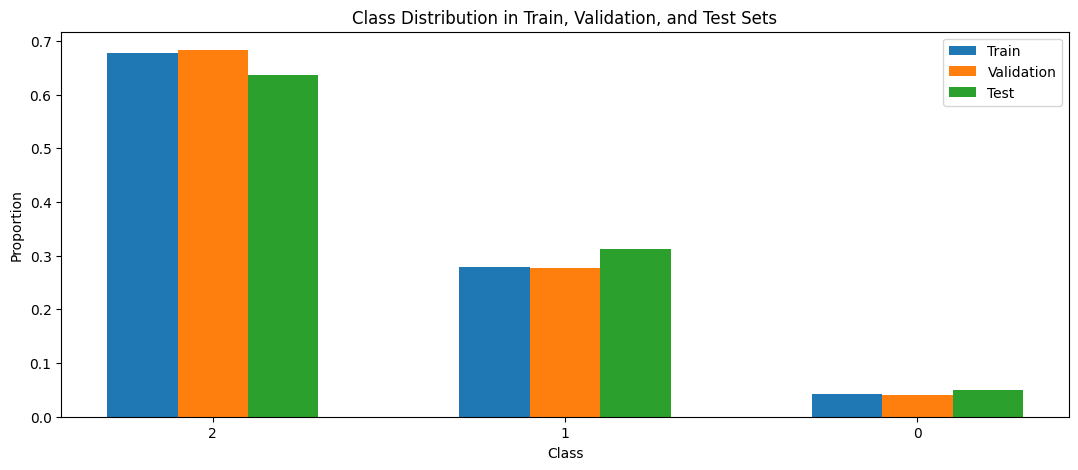

In [ ]:
import matplotlib.pyplot as plt

def plot_class_distribution(train_data, val_data, test_data, target_column):
    """
    Plots the class distribution for the training, validation, and test sets with distinct colors.

    Parameters:
    - train_data: DataFrame for the training set.
    - val_data: DataFrame for the validation set.
    - test_data: DataFrame for the test set.
    - target_column: Column name for the target variable (class label).
    """
    # Get class distribution for each set
    train_counts = train_data[target_column].value_counts(normalize=True)
    val_counts = val_data[target_column].value_counts(normalize=True)
    test_counts = test_data[target_column].value_counts(normalize=True)

    # Prepare plot data
    classes = train_counts.index
    bar_width = 0.20
    x = range(len(classes))

    # Colors for each dataset
    train_color = '#1f77b4'  # Blue
    val_color = '#ff7f0e'    # Orange
    test_color = '#2ca02c'   # Green

    # Create bar plot with distinct colors
    plt.figure(figsize=(13, 5))
    plt.bar(x, train_counts, width=bar_width, color=train_color, label="Train", align='center')
    plt.bar([p + bar_width for p in x], val_counts, width=bar_width, color=val_color, label="Validation", align='center')
    plt.bar([p + bar_width * 2 for p in x], test_counts, width=bar_width, color=test_color, label="Test", align='center')
    # Labeling
    plt.xlabel("Class")
    plt.ylabel("Proportion")
    plt.title("Class Distribution in Train, Validation, and Test Sets")
    plt.xticks([p + bar_width for p in x], classes)
    plt.legend()

    plt.show()

# Example usage after splitting the data
plot_class_distribution(train_data, val_data, test_data, target_column="Success_Label")  # Replace with actual target column name


## Checking the features distributions in training-, validation- & testsets

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18943 entries, 0 to 26847
Data columns (total 26 columns):
 #   Column                                                              Non-Null Count  Dtype         
---  ------                                                              --------------  -----         
 0   twitter_rating_mean                                                 18943 non-null  float64       
 1   twitter_rating_min                                                  18943 non-null  int64         
 2   twitter_rating_max                                                  18943 non-null  int64         
 3   twitter_number_users                                                18943 non-null  int64         
 4   from_imdb_imdb_id                                                   18943 non-null  object        
 5   daily_box_office_date_revenue_recorded                              18943 non-null  datetime64[ns]
 6   daily_box_office_TotalBoxOffice_lifespan                   

In [ ]:
train_data.columns

Index(['twitter_rating_mean', 'twitter_rating_min', 'twitter_rating_max',
       'twitter_number_users', 'from_imdb_imdb_id',
       'daily_box_office_date_revenue_recorded',
       'daily_box_office_TotalBoxOffice_lifespan',
       'daily_box_office_DailyBoxOfficeRevenue',
       'daily_box_office_accumulated_DailyBoxOfficeRevenues_since_Realease',
       'daily_box_office_%± YD gross change daily',
       'daily_box_office_%± LW gross change weekly',
       'daily_box_office_per theaters avg gross',
       'daily_box_office_Theaters_cleaned', 'Success_Label',
       'days_after_release', 'days_since_first_rating',
       'days_between_first_and_last_rating',
       'rolling_mean_trend_7_days_twitter_rating_mean',
       'slope_of_twitter_rating_mean', 'mean_diff_twitter_rating_mean',
       'lagged_corr_1_twitter_rating_mean',
       'autocorr_lag_1_twitter_rating_mean',
       'time_to_peak_twitter_rating_mean',
       'time_to_trough_twitter_rating_mean',
       'longest_increase_s

In [ ]:
features_for_plots = [
        #'rotten_review_date_converted',
       'rotten_review_score_encoded_mean',
       #'rotten_review_score_encoded_var',
       #'rotten_review_score_encoded_std',
       'rotten_rating_sentiment_polarity_mean',
       #'rotten_rating_sentiment_polarity_var',
       #'rotten_rating_sentiment_polarity_std',
       #'from_imdb_imdb_id',
        # 'daily_box_office_date_revenue_recorded',
       'daily_box_office_DailyBoxOfficeRevenue',
       'daily_box_office_%± YD gross change daily',
       'daily_box_office_%± LW gross change weekly',
       'daily_box_office_per theaters avg gross',
       'daily_box_office_Theaters_cleaned',
       #'Success_Label',
      #'days_after_release',
       #'days_since_first_rating',
       #'days_between_first_and_last_rating',
       'rolling_mean_trend_7_days_rotten_rating_sentiment_polarity_mean',
       'slope_of_rotten_rating_sentiment_polarity_mean',
       'mean_diff_rotten_rating_sentiment_polarity_mean',
       'lagged_corr_1_rotten_rating_sentiment_polarity_mean',
       'autocorr_lag_1_rotten_rating_sentiment_polarity_mean',
       'time_to_peak_rotten_rating_sentiment_polarity_mean',
       'time_to_trough_rotten_rating_sentiment_polarity_mean',
       'longest_increase_streak_rotten_rating_sentiment_polarity_mean',
       'longest_decrease_streak_rotten_rating_sentiment_polarity_mean'
       ]


features_for_plots = [
'twitter_rating_mean',
'twitter_rating_min',
'twitter_rating_max',
'twitter_number_users',
#'from_imdb_imdb_id',
#'daily_box_office_date_revenue_recorded',
'daily_box_office_TotalBoxOffice_lifespan',
'daily_box_office_DailyBoxOfficeRevenue',
'daily_box_office_accumulated_DailyBoxOfficeRevenues_since_Realease',
'daily_box_office_%± YD gross change daily',
'daily_box_office_%± LW gross change weekly',
'daily_box_office_per theaters avg gross',
'daily_box_office_Theaters_cleaned',
#'Success_Label',
#'days_after_release',
#'days_since_first_rating',
#'days_between_first_and_last_rating',
'rolling_mean_trend_7_days_twitter_rating_mean',
'slope_of_twitter_rating_mean',
'mean_diff_twitter_rating_mean',
'lagged_corr_1_twitter_rating_mean',
'autocorr_lag_1_twitter_rating_mean',
'time_to_peak_twitter_rating_mean',
'time_to_trough_twitter_rating_mean',
'longest_increase_streak_twitter_rating_mean',
'longest_decrease_streak_twitter_rating_mean'
       ]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def freedman_diaconis_bin_width(data):
    """Calculate bin width using Freedman-Diaconis rule."""
    iqr = np.percentile(data, 75) - np.percentile(data, 25)
    n = len(data)
    return 2 * iqr / np.cbrt(n)

def calculate_bin_size(data):
    """Calculates the number of bins based on Freedman-Diaconis rule."""
    bin_width = freedman_diaconis_bin_width(data)
    if bin_width > 0:
        return int((data.max() - data.min()) / bin_width)
    else:
        return 10  # fallback to a default if bin width is zero

def compare_feature_distributions(train_data, val_data, test_data, features_to_compare):
    """
    Visualizes and compares the distributions of numeric features across training, validation, and test sets.

    Parameters:
    - train_data: DataFrame for the training set.
    - val_data: DataFrame for the validation set.
    - test_data: DataFrame for the test set.
    - features_to_compare: List of feature names to compare.
    """
    # Select numeric features
    numeric_columns = train_data.select_dtypes(include=['float64', 'int64', 'float32', 'int32']).columns

    # Colors for each dataset
    train_color = '#1f77b4'  # Blue
    val_color = '#ff7f0e'    # Orange
    test_color = '#2ca02c'   # Green

    # check if features_to_compare are valid for plotting
    for column in features_to_compare:
        if column not in numeric_columns:
            raise ValueError(f"Feature '{column}' is not a numeric column.")

    # Iterate through each numeric feature
    for column in features_to_compare:
        # Determine bin size based on training data
        bin_count = calculate_bin_size(train_data[column].dropna())

        # Calculate common x-axis limits across all three sets for consistent scaling
        min_val = min(train_data[column].min(), val_data[column].min(), test_data[column].min())
        max_val = max(train_data[column].max(), val_data[column].max(), test_data[column].max())


        print(f"\n\nPlotting feature: {column}")

        # title for features statistics underline title
        print("-" * len(f"Plotting feature: {column}\n\n"))

        # Calculate and print statistics for each set
        print(f"Statistics for feature: {column}\n")
        # printing min, max, quartiles and mean values by creating first a Dataframe that has the values for the three and then printing the dataframe
        stats_df = pd.DataFrame({
            'Train': train_data[column].describe(),
            'Validation': val_data[column].describe(),
            'Test': test_data[column].describe()
        })

        print(stats_df)
        print("\n\n")

        fig, axes = plt.subplots(1, 4, figsize=(20, 7))

        # KDE Plot for all three sets
        sns.kdeplot(train_data[column], label='Train', ax=axes[0], fill=True, color=train_color)
        sns.kdeplot(val_data[column], label='Validation', ax=axes[0], fill=True, color=val_color)
        sns.kdeplot(test_data[column], label='Test', ax=axes[0], fill=True, color=test_color)
        axes[0].set_title(f"{column} - KDE Plot (All Sets)")
        axes[0].legend()

        # Histogram for Training Set
        sns.histplot(train_data[column], ax=axes[1], kde=False, color=train_color)
        axes[1].set_title(f"{column} - Training Set")
        axes[1].set_xlim(min_val, max_val)

        # Histogram for Validation Set
        sns.histplot(val_data[column], ax=axes[2], kde=False, color=val_color)
        axes[2].set_title(f"{column} - Validation Set")
        axes[2].set_xlim(min_val, max_val)

        # Histogram for Test Set
        sns.histplot(test_data[column], ax=axes[3], kde=False, color=test_color)
        axes[3].set_title(f"{column} - Test Set")
        axes[3].set_xlim(min_val, max_val)

        # Adjust layout
        plt.tight_layout()
        plt.show()

# Example usage after splitting the data
compare_feature_distributions(train_data, val_data, test_data, features_for_plots)


Output hidden; open in https://colab.research.google.com to view.

### Feature Distribution Analysis Insights

Based on the plots and statistical summaries provided, here are the insights extracted for each feature:

1. **`rotten_review_score_encoded_mean`**:
   - This feature has a consistent distribution across the train, validation, and test sets, centered around a mean of ~0.69, with a relatively narrow standard deviation of ~0.18. The values are bounded between 0 and 1, likely representing normalized scores. This feature has low variability and may primarily provide stability rather than strong differentiation across samples.

2. **`rotten_rating_sentiment_polarity_mean`**:
   - The mean sentiment polarity for Rotten Tomatoes ratings ranges broadly from -3 to 2.5, with a mean close to zero, indicating a balance between positive and negative sentiments. The high standard deviation (~0.95) across datasets suggests this feature captures a meaningful level of sentiment variability, which could be informative for distinguishing samples with different sentiment dynamics.

3. **`rolling_mean_trend_7_days_rotten_rating_sentiment_polarity_mean`**:
   - This rolling trend feature has values close to zero with a small standard deviation (~0.01), indicating minimal week-to-week change in sentiment polarity. This stability might suggest limited weekly trend fluctuations in sentiment, which may not provide substantial differentiation across samples.

4. **`slope_of_rotten_rating_sentiment_polarity_mean`**:
   - The slope of the sentiment polarity has a mean near zero and a very small range of values (around ±0.001), reflecting slight daily changes in sentiment polarity. This limited range suggests that daily shifts in sentiment are generally minimal, with most values centered close to zero, likely indicating stable sentiment trends.

5. **`mean_diff_rotten_rating_sentiment_polarity_mean`**:
   - The mean difference in sentiment polarity has a mean close to zero across datasets, with slightly higher variability than the trend or slope features. The wider range from -0.1 to 0.1 suggests that this feature captures meaningful differences in sentiment polarity, which could be informative for modeling temporal sentiment shifts within movies.

6. **`lagged_corr_1_rotten_rating_sentiment_polarity_mean`** and **`autocorr_lag_1_rotten_rating_sentiment_polarity_mean`**:
   - Both features measure correlation at a one-lag interval and show similar distributions across datasets, with slight negative means (~-0.01) and a standard deviation of ~0.14. These autocorrelation features may capture temporal dependencies in sentiment, which could be valuable in identifying recurring sentiment patterns or lags within each movie’s timeline.

7. **`time_to_peak_rotten_rating_sentiment_polarity_mean`**:
   - This feature has high variability, with values spanning from 0 to ~7000 and a high mean around 1000. This distribution, which is highly skewed with most values near the lower end, suggests that sentiment peaks quickly for most movies but takes significantly longer for others, making this feature potentially informative in differentiating movies with different sentiment timelines.

8. **`time_to_trough_rotten_rating_sentiment_polarity_mean`**:
   - Similar to the time-to-peak feature, the time-to-trough feature shows high variability and is also skewed towards lower values. With a mean around 850, this feature captures the duration to reach the lowest point in sentiment, providing insights into movies that experience rapid sentiment decline versus those with prolonged sentiment stabilization.

9. **`longest_increase_streak_rotten_rating_sentiment_polarity_mean`**:
   - This feature generally has low values, with most observations clustered around 3 and a maximum around 6-8. It suggests that sentiment increases in short streaks for most movies, with only a few cases of prolonged increases. This pattern may indicate consistent, yet modest, increases in sentiment.

10. **`longest_decrease_streak_rotten_rating_sentiment_polarity_mean`**:
    - The longest decrease streak feature behaves similarly to the increase streak feature, with most values around 3 and a maximum between 6 and 7. This limited streak duration suggests that sentiment declines are also typically short, indicating rapid sentiment recovery or fluctuation rather than extended declines.

These insights indicate that while some features (like time to peak/trough) exhibit high variability and skew, others (like trend and slope features) remain relatively stable across samples, providing distinct patterns that could support different aspects of predictive modeling. The sentiment features, especially polarity and autocorrelation, capture meaningful variability that could be crucial for understanding and predicting temporal sentiment dynamics.


## Checking the variance distributions in training-, validation- & testset

#### Total variance accross features

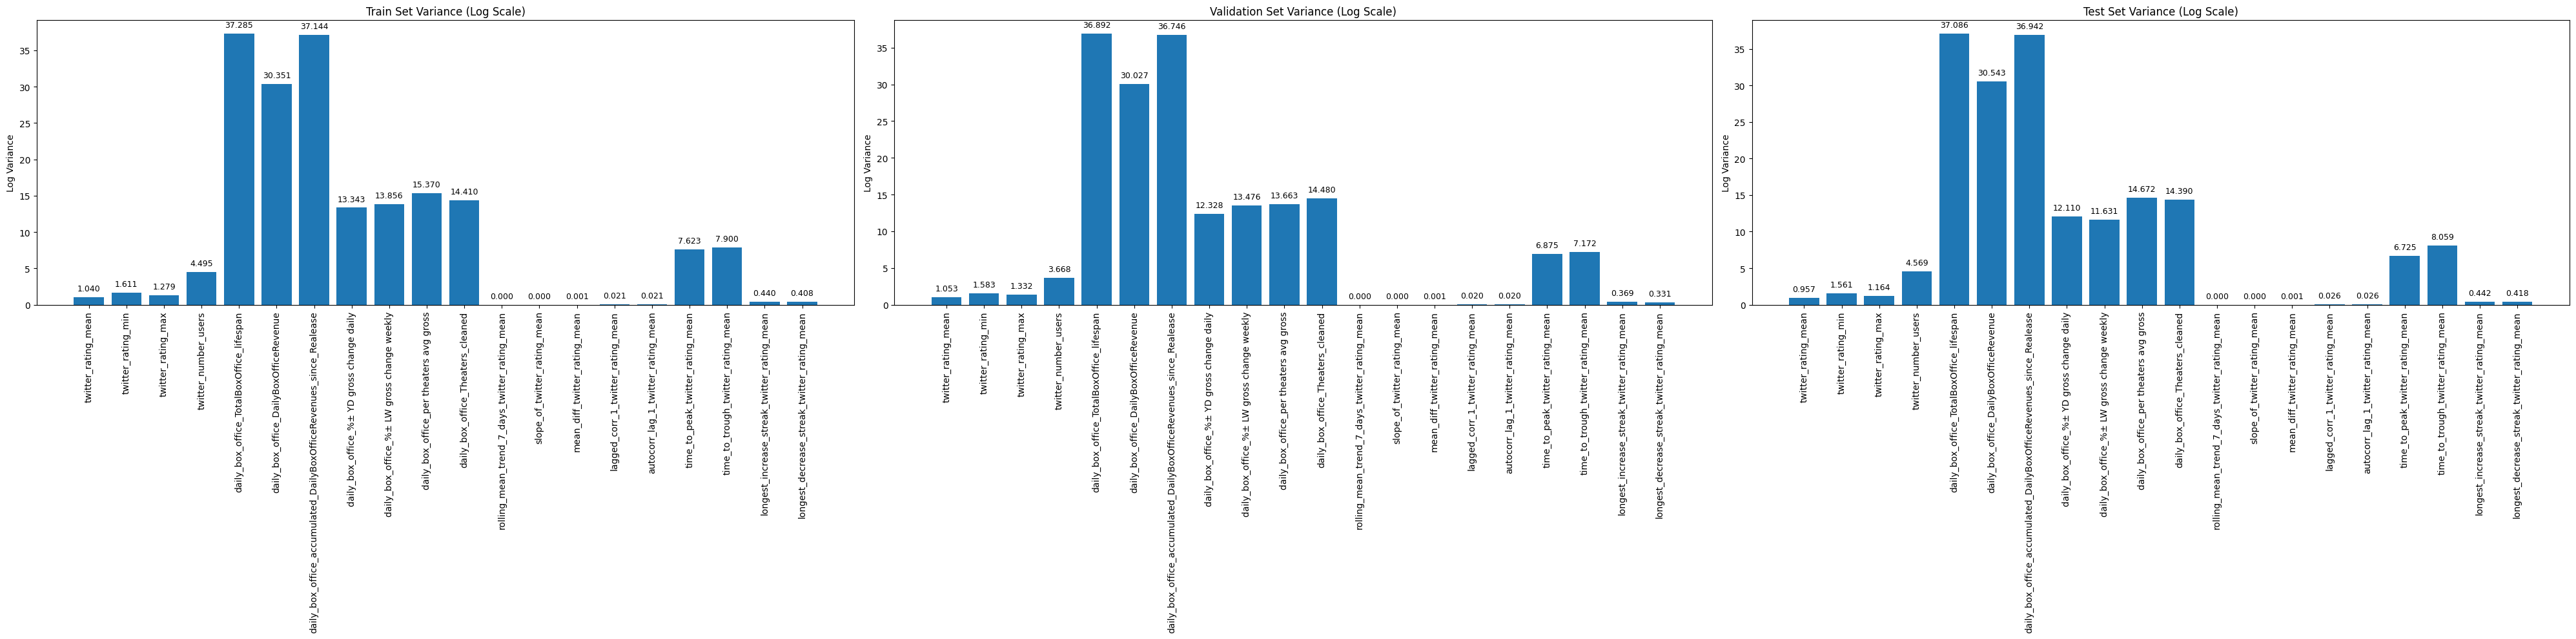

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_variance(train, validation, test, features):
    # Helper function to calculate variance and filter features
    def calculate_variance(data, features):
        # Filter only numeric features
        numeric_features = data[features].select_dtypes(include=[np.number])
        # Calculate variance and log-transform it
        feature_variance = numeric_features.var()
        return np.log1p(feature_variance)  # log1p to avoid log(0) issues

    # Calculate variance for each dataset
    train_variance = calculate_variance(train, features)
    val_variance = calculate_variance(validation, features)
    test_variance = calculate_variance(test, features)

    # Initialize the figure
    fig, axes = plt.subplots(1, 3, figsize=(40, 10))

    # Plot variance bar charts for each dataset with annotations
    for ax, (variance, title) in zip(
        axes,
        [(train_variance, "Train Set Variance (Log Scale)"),
         (val_variance, "Validation Set Variance (Log Scale)"),
         (test_variance, "Test Set Variance (Log Scale)")]
    ):
        ax.bar(variance.index, variance.values)
        ax.set_title(title)
        ax.set_ylabel("Log Variance")
        ax.tick_params(axis='x', rotation=90)

        # Annotate each bar with the variance value
        for i, (feature, var_value) in enumerate(variance.items()):
            ax.annotate(f"{var_value:.3f}",
                        xy=(i, var_value),
                        xytext=(0, 5),  # offset annotation slightly above the bar
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage:
plot_feature_variance(train_data, val_data, test_data, features_for_plots)


Conclusion Plot above:

#### Within movie Variance

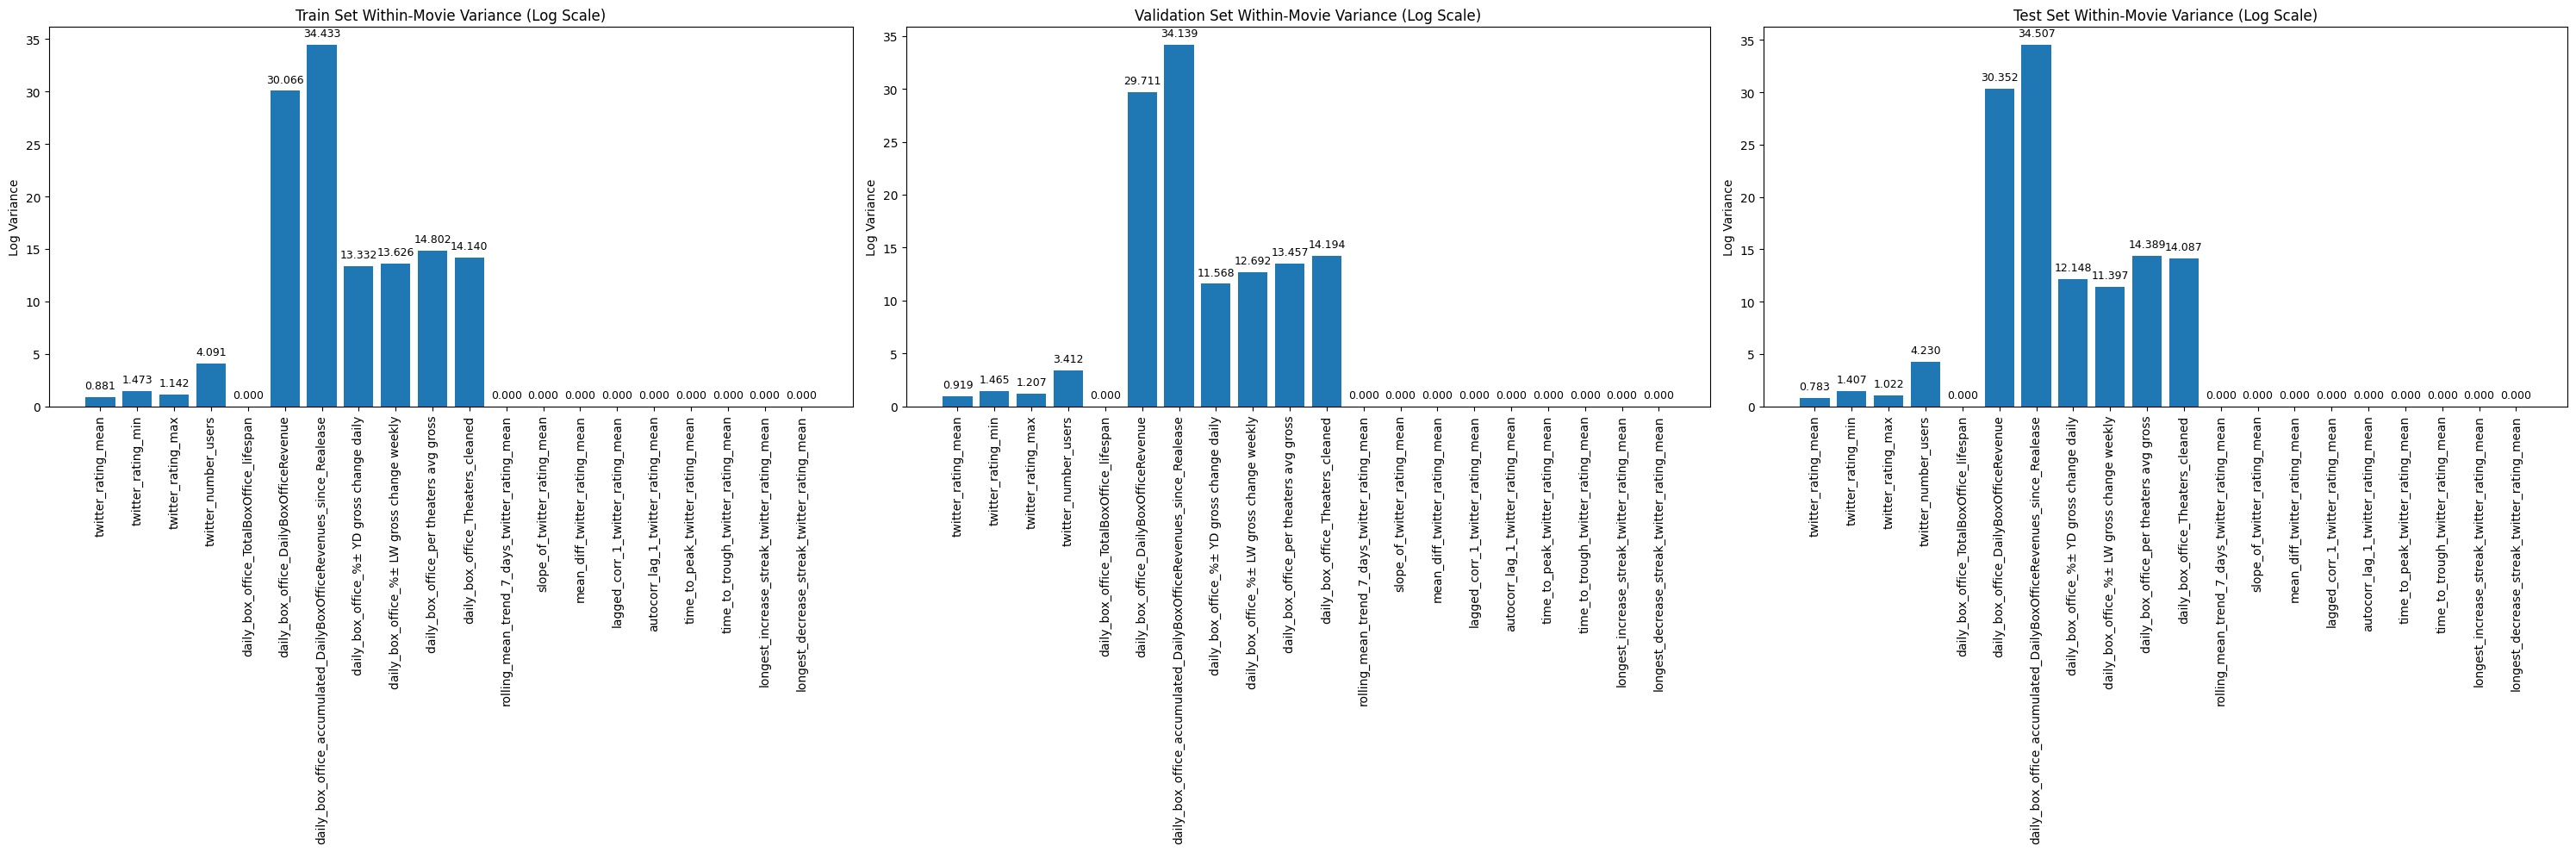

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_within_movie_feature_variance(train, validation, test, features, movie_id_col):
    # Helper function to calculate variance within each movie
    def calculate_within_movie_variance(data, features, movie_id_col):
        # Group by movie ID and calculate variance for each movie individually
        within_movie_variance = data.groupby(movie_id_col)[features].var()
        # Aggregate the variance across movies to get an overall sense of within-movie variance
        aggregated_variance = within_movie_variance.mean()  # you could also use median
        return np.log1p(aggregated_variance)  # log1p to avoid log(0) issues

    # Calculate within-movie variance for each dataset
    train_variance = calculate_within_movie_variance(train, features, movie_id_col)
    val_variance = calculate_within_movie_variance(validation, features, movie_id_col)
    test_variance = calculate_within_movie_variance(test, features, movie_id_col)

    # Initialize the figure
    fig, axes = plt.subplots(1, 3, figsize=(30, 10))

    # Plot variance bar charts for each dataset with annotations
    for ax, (variance, title) in zip(
        axes,
        [(train_variance, "Train Set Within-Movie Variance (Log Scale)"),
         (val_variance, "Validation Set Within-Movie Variance (Log Scale)"),
         (test_variance, "Test Set Within-Movie Variance (Log Scale)")]
    ):
        ax.bar(variance.index, variance.values)
        ax.set_title(title)
        ax.set_ylabel("Log Variance")
        ax.tick_params(axis='x', rotation=90)

        # Annotate each bar with the variance value
        for i, (feature, var_value) in enumerate(variance.items()):
            ax.annotate(f"{var_value:.3f}",
                        xy=(i, var_value),
                        xytext=(0, 5),  # offset annotation slightly above the bar
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage:
plot_within_movie_feature_variance(train_data, val_data, test_data, features_for_plots, movie_id_col='from_imdb_imdb_id')
